# Домашнее задание №4
Формулируем задачу в терминах ML

*Выполнила Бегушева Элина*

## Часть 1. Загрузка и первичный анализ данных

Импорт используемых библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, f1_score, roc_auc_score, average_precision_score
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from lazypredict.Supervised import LazyClassifier
from tqdm.auto import tqdm  # заменит notebook_tqdm
import lazypredict.Supervised
lazypredict.Supervised.notebook_tqdm = tqdm  # патч
import networkx as nx
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score


### 1.1 Загрузка, преобразование и описание датасета

*Источник*: https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml

In [21]:
df = pd.read_csv("SAML-D.csv")

In [3]:
n_rows, n_cols = df.shape

print(f" ❗Размер датасета: {n_rows:,} строк × {n_cols} столбцов")

numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\n❗Числовые колонки: {numerical_cols}")
print(f"\n❗Категориальные колонки: {categorical_cols}")

print("\n ❗Первые 5 строк:")
display(df.head())

print("\n ❗Информация о типе столбцов:")
df.info()

print("\n ❗Описательные статистики:")
display(df.describe())

print("\n ❗Количество провусков в каждом столбце:")
display(df.isnull().sum())

class_counts = df["Is_laundering"].value_counts().sort_index()
class_percent = (class_counts / len(df) * 100).round(4)

balance_df = pd.DataFrame({
    "Класс": ["Обычные транзакции (0)", "Отмывание (1)"],
    "Количество": class_counts.values,
    "Доля (%)": class_percent.values
})

print("\n ❗Баланс классов:")
display(balance_df)

print("\n ❗Количество уникальных значений по столбцам:")
unique_counts = df.nunique().sort_values(ascending=False)
display(unique_counts)

missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if missing_values.empty:
    print("\n❗Пропущенных значений нет")
else:
    print("\n❗Пропущенные значения:")
    display(missing_values)

numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

duplicate_count = df.duplicated().sum()
print(f"\n❗Количество дублирующихся строк: {duplicate_count}")

 ❗Размер датасета: 9,504,852 строк × 12 столбцов

❗Числовые колонки: ['Sender_account', 'Receiver_account', 'Amount', 'Is_laundering']

❗Категориальные колонки: ['Time', 'Date', 'Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Laundering_type']

 ❗Первые 5 строк:


,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits



 ❗Информация о типе столбцов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    object 
 1   Date                    object 
 2   Sender_account          int64  
 3   Receiver_account        int64  
 4   Amount                  float64
 5   Payment_currency        object 
 6   Received_currency       object 
 7   Sender_bank_location    object 
 8   Receiver_bank_location  object 
 9   Payment_type            object 
 10  Is_laundering           int64  
 11  Laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 870.2+ MB

 ❗Описательные статистики:


,Sender_account,Receiver_account,Amount,Is_laundering
count,9504852.00,9504852.00,9504852.00,9504852.00
mean,5006619409.97,5006006469.65,8762.97,0.00
std,2885813892.13,2884762983.27,25614.95,0.03
min,9018.00,9018.00,3.73,0.00
25%,2513133245.00,2513219464.00,2143.69,0.00
50%,5001016667.00,5002572491.50,6113.72,0.00
75%,7505051146.00,7502397427.00,10458.46,0.00
max,9999986843.00,9999971095.00,12618498.40,1.00



 ❗Количество провусков в каждом столбце:


Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
dtype: int64


 ❗Баланс классов:


,Класс,Количество,Доля (%)
0,Обычные транзакции (0),9494979,99.90
1,Отмывание (1),9873,0.10



 ❗Количество уникальных значений по столбцам:


Amount                    2314277
Receiver_account           652266
Sender_account             292715
Time                        86400
Date                          321
Laundering_type                28
Receiver_bank_location         18
Sender_bank_location           18
Received_currency              13
Payment_currency               13
Payment_type                    7
Is_laundering                   2
dtype: int64


❗Пропущенных значений нет

❗Количество дублирующихся строк: 0


**Преобразование даты: выделяем год, месяц, день недели, час**

In [22]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce", format="%Y-%m-%d")

df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["weekday"] = df["Date"].dt.weekday + 1
df["hour"] = df["Time"].str[:2].astype(int)

In [23]:
df['hour'] = df['hour'].astype('category')
df['weekday'] = df['weekday'].astype('category')
df['month'] = df['month'].astype('category')
df['year'] = df['year'].astype('category')

In [8]:
print(f"❗Начало диапазона: {df['Date'].min().date()}")
print(f"\n❗Конец диапазона:  {df['Date'].max().date()}")

❗Начало диапазона: 2022-10-07

❗Конец диапазона:  2023-08-23


__Преобразования для Amount не требуются__, так как "Валюта для «Суммы» — британские фунты (£)" 

*Источник*: https://www.kaggle.com/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml/discussion/510003

**Преобразование валюты: преобразуем в формат ISO**

In [24]:
payment_currencies = set(df["Payment_currency"].unique())
received_currencies = set(df["Received_currency"].unique())

all_currencies = sorted(payment_currencies.union(received_currencies))

print("Все валюты, встречающиеся в датасете")
for currency in all_currencies:
    print("-", currency)

Все валюты, встречающиеся в датасете
- Albanian lek
- Dirham
- Euro
- Indian rupee
- Mexican Peso
- Moroccan dirham
- Naira
- Pakistani rupee
- Swiss franc
- Turkish lira
- UK pounds
- US dollar
- Yen


In [25]:
# Создание датафрейма с расшифровкой ISO-кодов
currency_names = {
    "GBP": "UK pounds",
    "EUR": "Euro",
    "JPY": "Yen",
    "TRY": "Turkish lira",
    "CHF": "Swiss franc",
    "USD": "US dollar",
    "AED": "Dirham",
    "INR": "Indian rupee",
    "NGN": "Naira",
    "PKR": "Pakistani rupee",
    "MAD": "Moroccan dirham",
    "ALL": "Albanian lek",
    "MXN": "Mexican Peso"
}

currency_df = pd.DataFrame(list(currency_names.items()), columns=["ISO-код", "Оригинальное обозначение"])

currency_df.sort_values("ISO-код").reset_index(drop=True)

,ISO-код,Оригинальное обозначение
0,AED,Dirham
1,ALL,Albanian lek
2,CHF,Swiss franc
3,EUR,Euro
4,GBP,UK pounds
5,INR,Indian rupee
6,JPY,Yen
7,MAD,Moroccan dirham
8,MXN,Mexican Peso
9,NGN,Naira


In [26]:
currency_names_reversed = {v: k for k, v in currency_names.items()}

In [27]:
df["Payment_currency_iso"] = df["Payment_currency"].map(currency_names_reversed)
df["Received_currency_iso"] = df["Received_currency"].map(currency_names_reversed)

In [28]:
df = df.drop(columns=["Payment_currency", "Received_currency"])

In [14]:
n_rows, n_cols = df.shape

print(f" ❗Размер датасета: {n_rows:,} строк × {n_cols} столбцов")

umerical_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\n❗Числовые колонки: {numerical_cols}")
print(f"\n❗Категориальные колонки: {categorical_cols}")

print("\n ❗Первые 5 строк:")
display(df.head())

print("\n ❗Информация о типе столбцов:")
df.info()

print("\n ❗Описательные статистики:")
display(df.describe())

class_counts = df["Is_laundering"].value_counts().sort_index()
class_percent = (class_counts / len(df) * 100).round(4)

balance_df = pd.DataFrame({
    "Класс": ["Обычные транзакции (0)", "Отмывание (1)"],
    "Количество": class_counts.values,
    "Доля (%)": class_percent.values
})

print("\n ❗Баланс классов:")
display(balance_df)

print("\n ❗Количество уникальных значений по столбцам:")
unique_counts = df.nunique().sort_values(ascending=False)
display(unique_counts)

missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if missing_values.empty:
    print("\n❗Пропущенных значений нет")
else:
    print("\n❗Пропущенные значения:")
    display(missing_values)

numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

duplicate_count = df.duplicated().sum()
print(f"\n❗Количество дублирующихся строк: {duplicate_count}")


 ❗Размер датасета: 9,504,852 строк × 16 столбцов

❗Числовые колонки: ['Sender_account', 'Receiver_account', 'Amount', 'Is_laundering']

❗Категориальные колонки: ['Time', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Laundering_type', 'year', 'month', 'weekday', 'hour', 'Payment_currency_iso', 'Received_currency_iso']

 ❗Первые 5 строк:


,Time,Date,Sender_account,Receiver_account,Amount,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type,year,month,weekday,hour,Payment_currency_iso,Received_currency_iso
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,2022,10,5,10,GBP,GBP
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK,UAE,Cross-border,0,Normal_Fan_Out,2022,10,5,10,GBP,AED
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK,UK,Cheque,0,Normal_Small_Fan_Out,2022,10,5,10,GBP,GBP
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK,UK,ACH,0,Normal_Fan_In,2022,10,5,10,GBP,GBP
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,2022,10,5,10,GBP,GBP



 ❗Информация о типе столбцов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 16 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Time                    object        
 1   Date                    datetime64[ns]
 2   Sender_account          int64         
 3   Receiver_account        int64         
 4   Amount                  float64       
 5   Sender_bank_location    object        
 6   Receiver_bank_location  object        
 7   Payment_type            object        
 8   Is_laundering           int64         
 9   Laundering_type         object        
 10  year                    category      
 11  month                   category      
 12  weekday                 category      
 13  hour                    category      
 14  Payment_currency_iso    object        
 15  Received_currency_iso   object        
dtypes: category(4), datetime64[ns](1), float64(1), int64(3), ob

,Date,Sender_account,Receiver_account,Amount,Is_laundering
count,9504852,9504852.00,9504852.00,9504852.00,9504852.00
mean,2023-03-15 21:03:37.048723968,5006619409.97,5006006469.65,8762.97,0.00
min,2022-10-07 00:00:00,9018.00,9018.00,3.73,0.00
25%,2022-12-27 00:00:00,2513133245.00,2513219464.00,2143.69,0.00
50%,2023-03-15 00:00:00,5001016667.00,5002572491.50,6113.72,0.00
75%,2023-06-03 00:00:00,7505051146.00,7502397427.00,10458.46,0.00
max,2023-08-23 00:00:00,9999986843.00,9999971095.00,12618498.40,1.00
std,NaN,2885813892.13,2884762983.27,25614.95,0.03



 ❗Баланс классов:


,Класс,Количество,Доля (%)
0,Обычные транзакции (0),9494979,99.90
1,Отмывание (1),9873,0.10



 ❗Количество уникальных значений по столбцам:


Amount                    2314277
Receiver_account           652266
Sender_account             292715
Time                        86400
Date                          321
Laundering_type                28
hour                           24
Sender_bank_location           18
Receiver_bank_location         18
Payment_currency_iso           13
Received_currency_iso          13
month                          11
Payment_type                    7
weekday                         7
year                            2
Is_laundering                   2
dtype: int64


❗Пропущенных значений нет

❗Количество дублирующихся строк: 0


### 1.1* Типы отмывания (в бейзлайне не используются)

In [15]:
laundering_mapping = (
    df[["Laundering_type", "Is_laundering"]]
    .drop_duplicates()
    .sort_values(by=["Laundering_type", "Is_laundering"])
    .reset_index(drop=True)
)

display(laundering_mapping)

,Laundering_type,Is_laundering
0,Behavioural_Change_1,1
1,Behavioural_Change_2,1
2,Bipartite,1
3,Cash_Withdrawal,1
4,Cycle,1
5,Deposit-Send,1
6,Fan_In,1
7,Fan_Out,1
8,Gather-Scatter,1
9,Layered_Fan_In,1


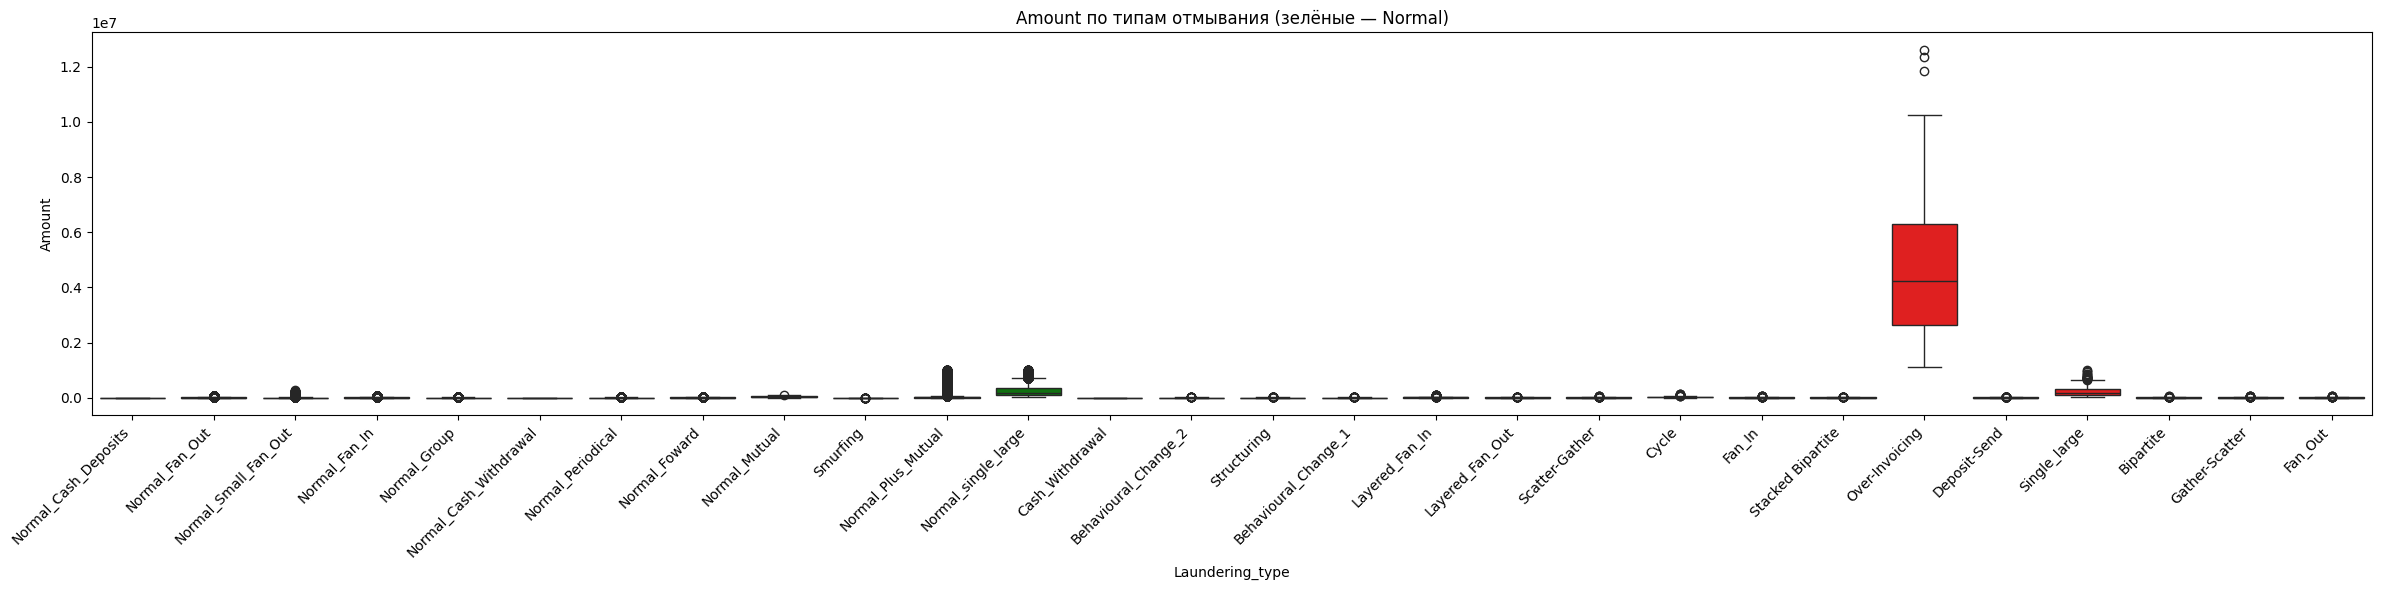

In [16]:
# создаём колонку-флаг: True, если Laundering_type начинается с 'Normal'
df['Is_Normal'] = df['Laundering_type'].str.startswith('Normal')

# создаём палитру: зелёный для Normal, красный для остальных
palette = {
    laundering_type: 'green' if is_normal else 'red'
    for laundering_type, is_normal in zip(
        df['Laundering_type'].unique(),
        df.groupby('Laundering_type')['Is_Normal'].first()
    )
}

# строим график
plt.figure(figsize=(24, 6))  # можно увеличить ширину при необходимости
sns.boxplot(x='Laundering_type', y='Amount', data=df, palette=palette)
plt.xticks(rotation=45, ha='right')
plt.title('Amount по типам отмывания (зелёные — Normal)')
plt.tight_layout()
plt.show()

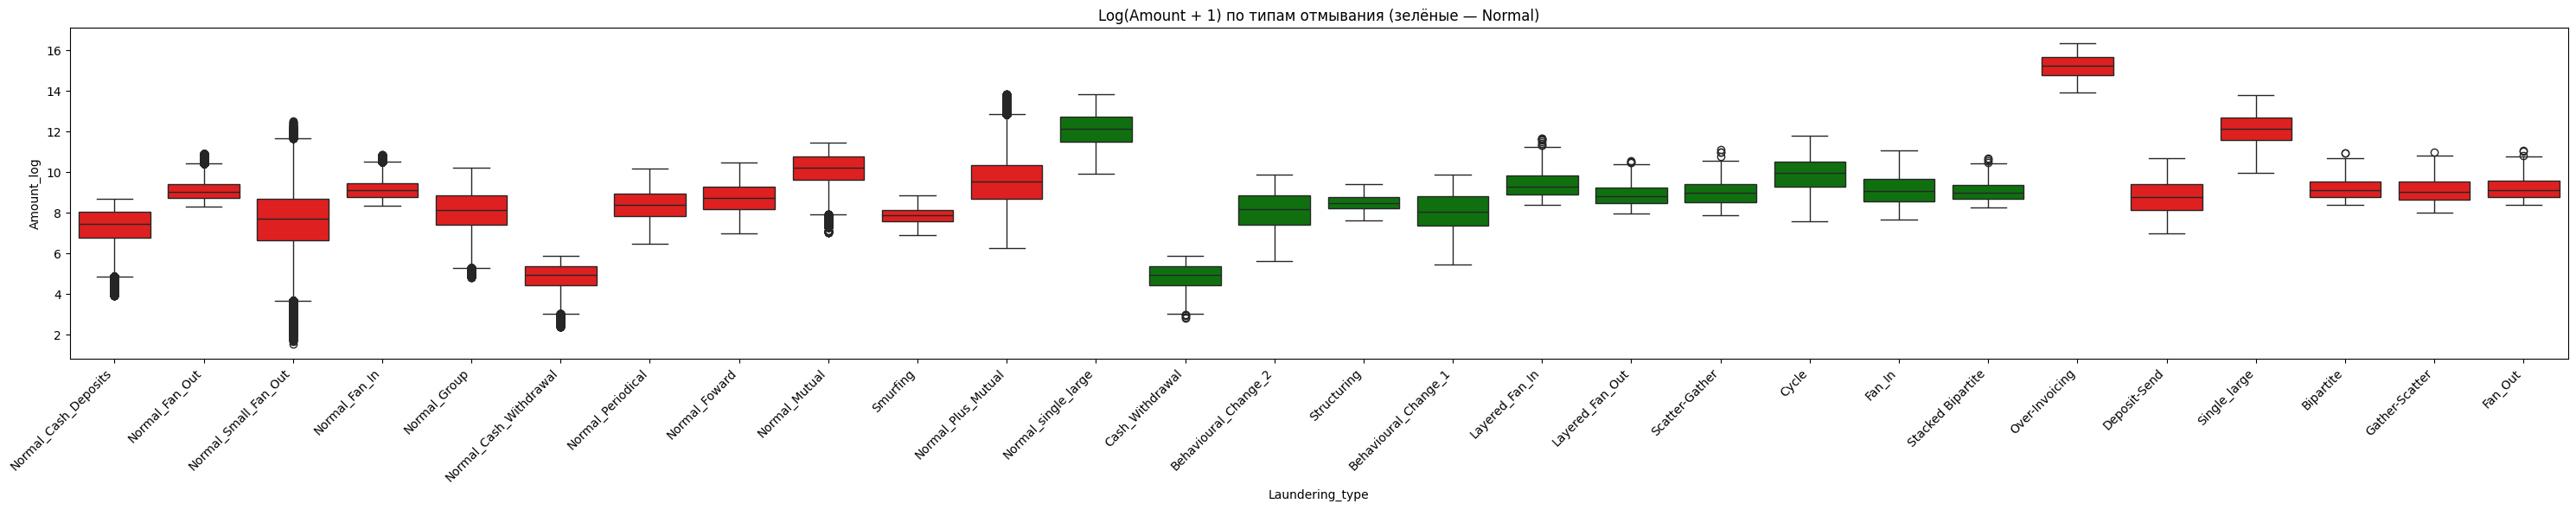

In [17]:
# Создание логарифмированной переменной
df['Amount_log'] = np.log1p(df['Amount'])

# Создаем колонку, определяющую цвет: True, если тип начинается с 'Normal'
df['Is_Normal'] = df['Laundering_type'].str.startswith('Normal')

# Генерируем цветовую палитру
palette = {lt: 'green' if is_normal else 'red' 
           for lt, is_normal in zip(df['Laundering_type'].unique(), 
                                     df.groupby('Laundering_type')['Is_Normal'].first())}

# График логарифмического распределения
plt.figure(figsize=(30, 6))
sns.boxplot(x='Laundering_type', y='Amount_log', data=df, palette=palette)
plt.xticks(rotation=45, ha='right')
plt.title('Log(Amount + 1) по типам отмывания (зелёные — Normal)')
plt.tight_layout()
plt.show()

### 1.2 Дата, время

In [18]:
time_cols = ["year", "month", "weekday", "hour"]

df[time_cols].describe().T

,count,unique,top,freq
year,9504852,2,2023,6998236
month,9504852,11,5,917601
weekday,9504852,7,1,1389246
hour,9504852,24,13,540796


**Распределение всех транзакций и транзакций с алертом по дням недели**

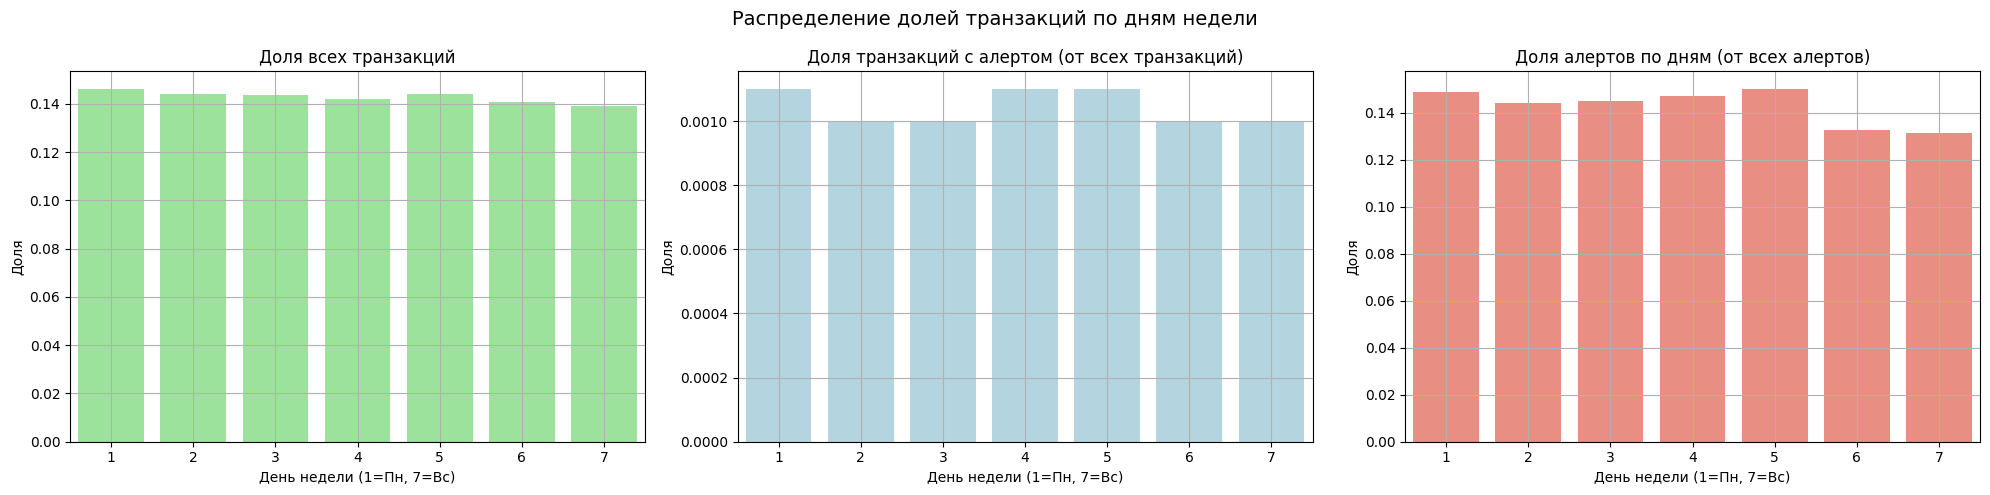

In [19]:
day_data = df.groupby("weekday")["Is_laundering"].agg(
    count="count",
    laundering_count="sum"
).reset_index()

day_data["laundering_rate"] = (day_data["laundering_count"] / day_data["count"]).round(4)

total_laundering = day_data["laundering_count"].sum()
day_data["laundering_share_overall"] = (day_data["laundering_count"] / total_laundering).round(4)

weekday_share = (
    df["weekday"].value_counts(normalize=True)
    .sort_index()
    .rename_axis("weekday")
    .reset_index(name="share")
)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.barplot(data=weekday_share, x="weekday", y="share", color="lightgreen", ax=axes[0])
axes[0].set_title("Доля всех транзакций")
axes[0].set_xlabel("День недели (1=Пн, 7=Вс)")
axes[0].set_ylabel("Доля")
axes[0].grid()

sns.barplot(data=day_data, x="weekday", y="laundering_rate", color="lightblue", ax=axes[1])
axes[1].set_title("Доля транзакций с алертом (от всех транзакций)")
axes[1].set_xlabel("День недели (1=Пн, 7=Вс)")
axes[1].set_ylabel("Доля")
axes[1].grid()

sns.barplot(data=day_data, x="weekday", y="laundering_share_overall", color="salmon", ax=axes[2])
axes[2].set_title("Доля алертов по дням (от всех алертов)")
axes[2].set_xlabel("День недели (1=Пн, 7=Вс)")
axes[2].set_ylabel("Доля")
axes[2].grid()

plt.suptitle("Распределение долей транзакций по дням недели", fontsize=14)
plt.tight_layout()
plt.show()

**Распределение всех транзакций и транзакций с алертом по часам**

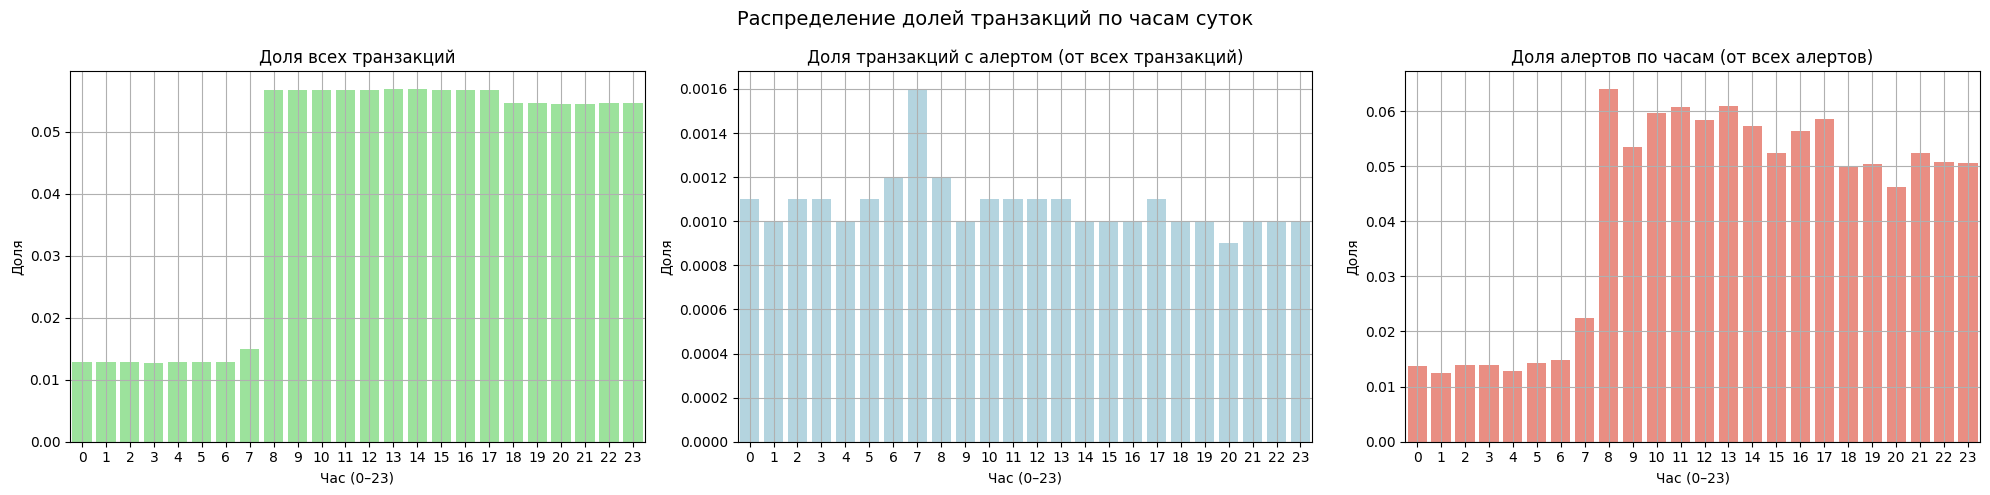

In [20]:
hour_share = (
    df["hour"].value_counts(normalize=True)
    .sort_index()
    .rename_axis("hour")
    .reset_index(name="share")
)

hour_data = df.groupby("hour")["Is_laundering"].agg(
    count="count",
    laundering_count="sum"
).reset_index()

hour_data["laundering_rate"] = (hour_data["laundering_count"] / hour_data["count"]).round(4)

total_laundering = hour_data["laundering_count"].sum()
hour_data["laundering_share_overall"] = (hour_data["laundering_count"] / total_laundering).round(4)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.barplot(data=hour_share, x="hour", y="share", color="lightgreen", ax=axes[0])
axes[0].set_title("Доля всех транзакций")
axes[0].set_xlabel("Час (0–23)")
axes[0].set_ylabel("Доля")
axes[0].grid()

sns.barplot(data=hour_data, x="hour", y="laundering_rate", color="lightblue", ax=axes[1])
axes[1].set_title("Доля транзакций с алертом (от всех транзакций)")
axes[1].set_xlabel("Час (0–23)")
axes[1].set_ylabel("Доля")
axes[1].grid()

sns.barplot(data=hour_data, x="hour", y="laundering_share_overall", color="salmon", ax=axes[2])
axes[2].set_title("Доля алертов по часам (от всех алертов)")
axes[2].set_xlabel("Час (0–23)")
axes[2].set_ylabel("Доля")
axes[2].grid()

plt.suptitle("Распределение долей транзакций по часам суток", fontsize=14)
plt.tight_layout()
plt.show()

**Распределение всех транзакций и транзакций с алертом по месяцам**

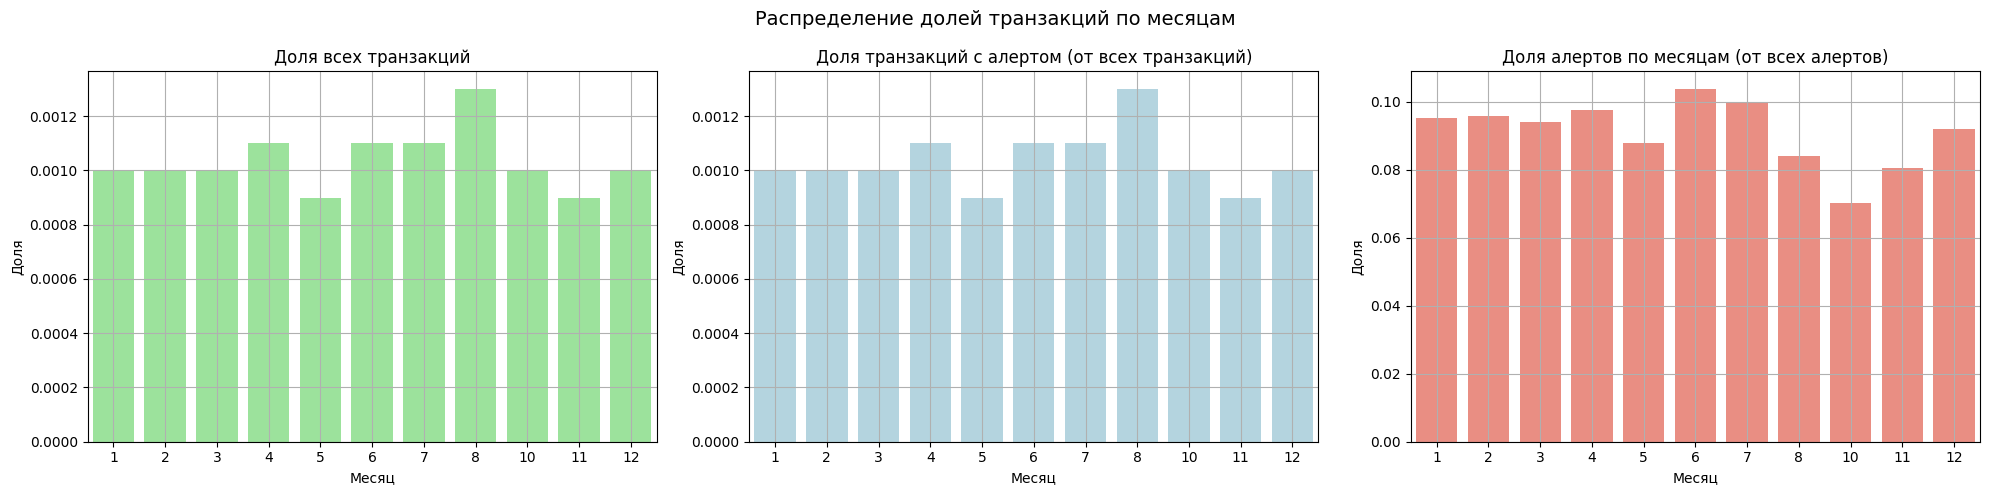

In [21]:
month_data = df.groupby("month")["Is_laundering"].agg(
    count="count",
    laundering_count="sum"
).reset_index()

month_data["laundering_rate"] = (month_data["laundering_count"] / month_data["count"]).round(4)

total_laundering = month_data["laundering_count"].sum()
month_data["laundering_share_overall"] = (month_data["laundering_count"] / total_laundering).round(4)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.barplot(data=month_data, x="month", y="laundering_rate", color="lightgreen", ax=axes[0])
axes[0].set_title("Доля всех транзакций")
axes[0].set_xlabel("Месяц")
axes[0].set_ylabel("Доля")
axes[0].grid()

sns.barplot(data=month_data, x="month", y="laundering_rate", color="lightblue", ax=axes[1])
axes[1].set_title("Доля транзакций с алертом (от всех транзакций)")
axes[1].set_xlabel("Месяц")
axes[1].set_ylabel("Доля")
axes[1].grid()

sns.barplot(data=month_data, x="month", y="laundering_share_overall", color="salmon", ax=axes[2])
axes[2].set_title("Доля алертов по месяцам (от всех алертов)")
axes[2].set_xlabel("Месяц")
axes[2].set_ylabel("Доля")
axes[2].grid()

plt.suptitle("Распределение долей транзакций по месяцам", fontsize=14)
plt.tight_layout()
plt.show()

**Распределение всех транзакций и транзакций с алертом по годам**

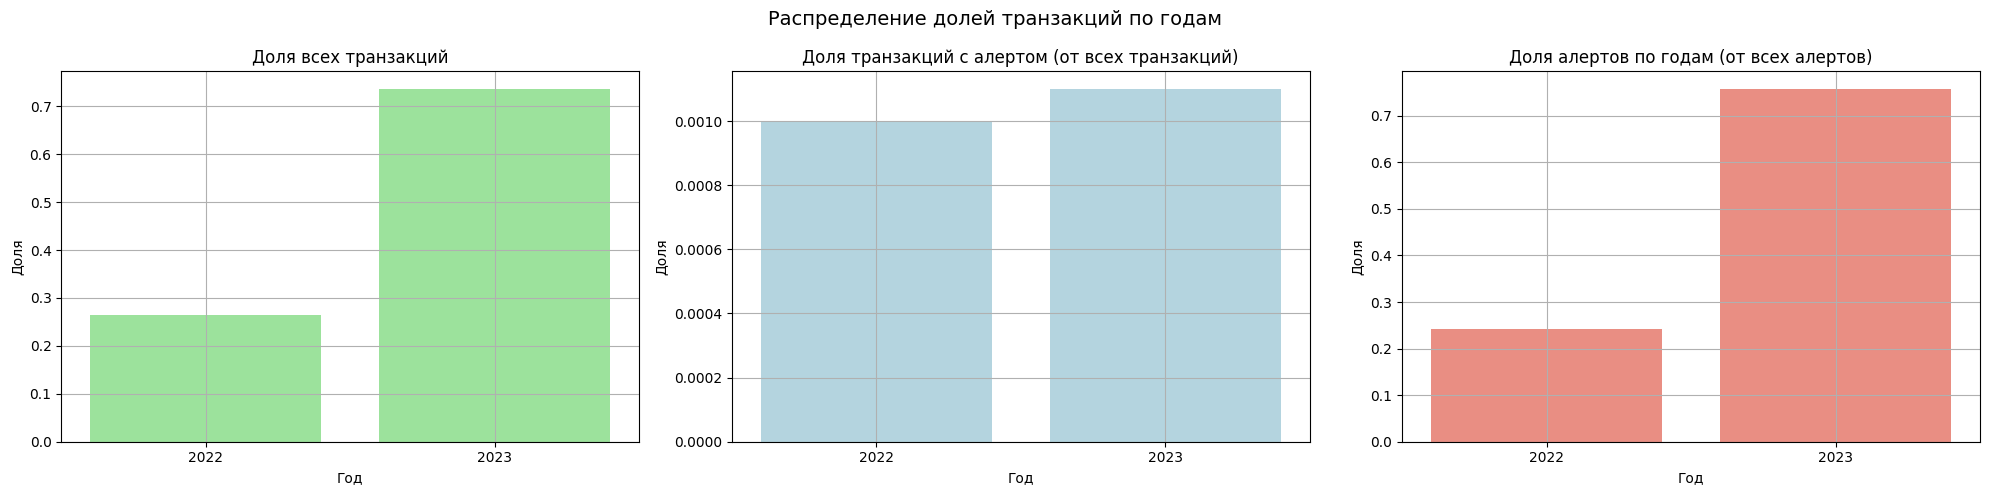

In [22]:
year_share = (
    df["year"].value_counts(normalize=True)
    .sort_index()
    .rename_axis("year")
    .reset_index(name="share")
)

year_data = df.groupby("year")["Is_laundering"].agg(
    count="count",
    laundering_count="sum"
).reset_index()

year_data["laundering_rate"] = (year_data["laundering_count"] / year_data["count"]).round(4)

total_laundering = year_data["laundering_count"].sum()
year_data["laundering_share_overall"] = (year_data["laundering_count"] / total_laundering).round(4)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.barplot(data=year_share, x="year", y="share", color="lightgreen", ax=axes[0])
axes[0].set_title("Доля всех транзакций")
axes[0].set_xlabel("Год")
axes[0].set_ylabel("Доля")
axes[0].grid()

sns.barplot(data=year_data, x="year", y="laundering_rate", color="lightblue", ax=axes[1])
axes[1].set_title("Доля транзакций с алертом (от всех транзакций)")
axes[1].set_xlabel("Год")
axes[1].set_ylabel("Доля")
axes[1].grid()

sns.barplot(data=year_data, x="year", y="laundering_share_overall", color="salmon", ax=axes[2])
axes[2].set_title("Доля алертов по годам (от всех алертов)")
axes[2].set_xlabel("Год")
axes[2].set_ylabel("Доля")
axes[2].grid()

plt.suptitle("Распределение долей транзакций по годам", fontsize=14)
plt.tight_layout()
plt.show()

**Распределение всех транзакций и транзакций с алертом по часам для каждого дня недели**

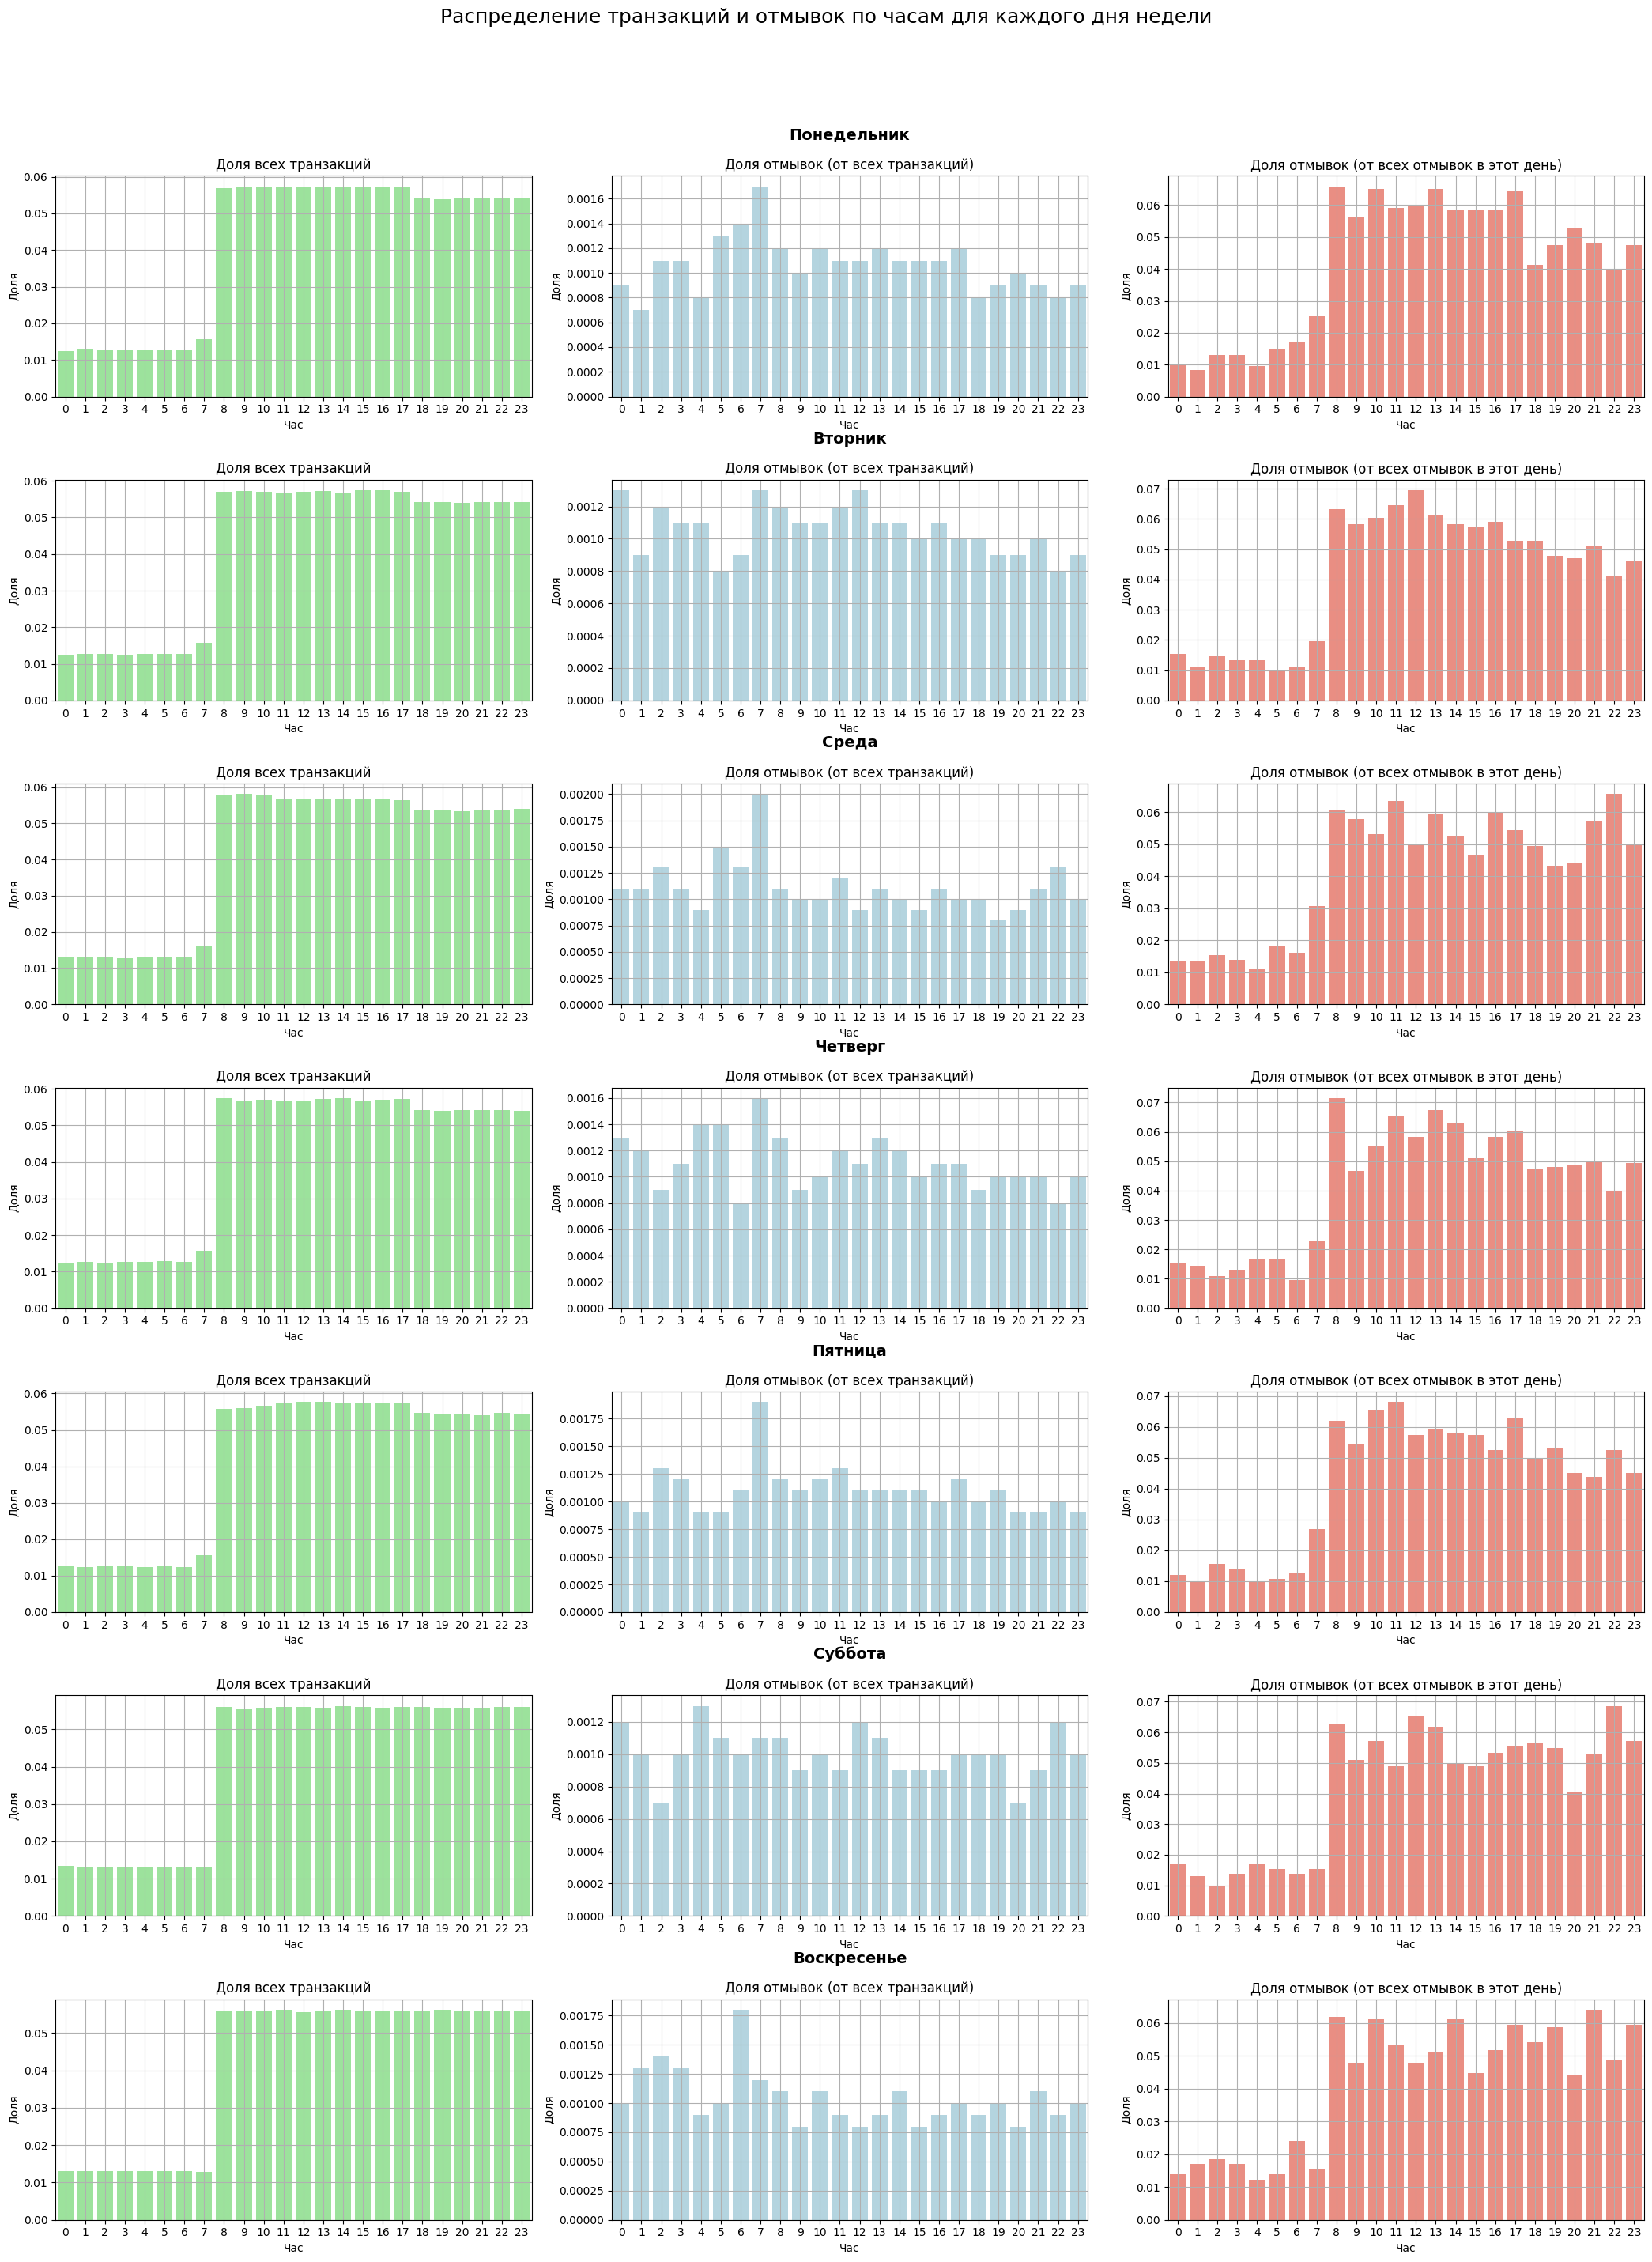

In [23]:
weekday_names = {
    1: "Понедельник",
    2: "Вторник",
    3: "Среда",
    4: "Четверг",
    5: "Пятница",
    6: "Суббота",
    7: "Воскресенье"
}

fig, axes = plt.subplots(7, 3, figsize=(21, 28))
plt.subplots_adjust(hspace=0.8)

for i, day in enumerate(range(1, 8)):
    df_day = df[df["weekday"] == day]
    day_name = weekday_names[day]

    hour_share = (
        df_day["hour"].value_counts(normalize=True)
        .sort_index()
        .rename_axis("hour")
        .reset_index(name="share")
    )

    hour_laundering = df_day.groupby("hour")["Is_laundering"].agg(
        count="count",
        laundering_count="sum"
    ).reset_index()

    hour_laundering["rate"] = (
        hour_laundering["laundering_count"] / hour_laundering["count"]
    ).round(4)

    total_laundering = hour_laundering["laundering_count"].sum()
    hour_laundering["share_overall"] = (
        hour_laundering["laundering_count"] / total_laundering
        if total_laundering > 0 else 0
    ).round(4)

    sns.barplot(data=hour_share, x="hour", y="share", color="lightgreen", ax=axes[i, 0])
    axes[i, 0].set_title("Доля всех транзакций")
    axes[i, 0].set_xlabel("Час")
    axes[i, 0].set_ylabel("Доля")
    axes[i, 0].grid()

  
    sns.barplot(data=hour_laundering, x="hour", y="rate", color="lightblue", ax=axes[i, 1])
    axes[i, 1].set_title("Доля отмывок (от всех транзакций)")
    axes[i, 1].set_xlabel("Час")
    axes[i, 1].set_ylabel("Доля")
    axes[i, 1].grid()

    axes[i, 1].text(0.5, 1.15, day_name,
                   fontsize=14, fontweight='bold',
                   ha='center', va='bottom', transform=axes[i, 1].transAxes)

    sns.barplot(data=hour_laundering, x="hour", y="share_overall", color="salmon", ax=axes[i, 2])
    axes[i, 2].set_title("Доля отмывок (от всех отмывок в этот день)")
    axes[i, 2].set_xlabel("Час")
    axes[i, 2].set_ylabel("Доля")
    axes[i, 2].grid()

plt.suptitle("Распределение транзакций и отмывок по часам для каждого дня недели", fontsize=18, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**Анализ объёма и числа транзакций по дням**

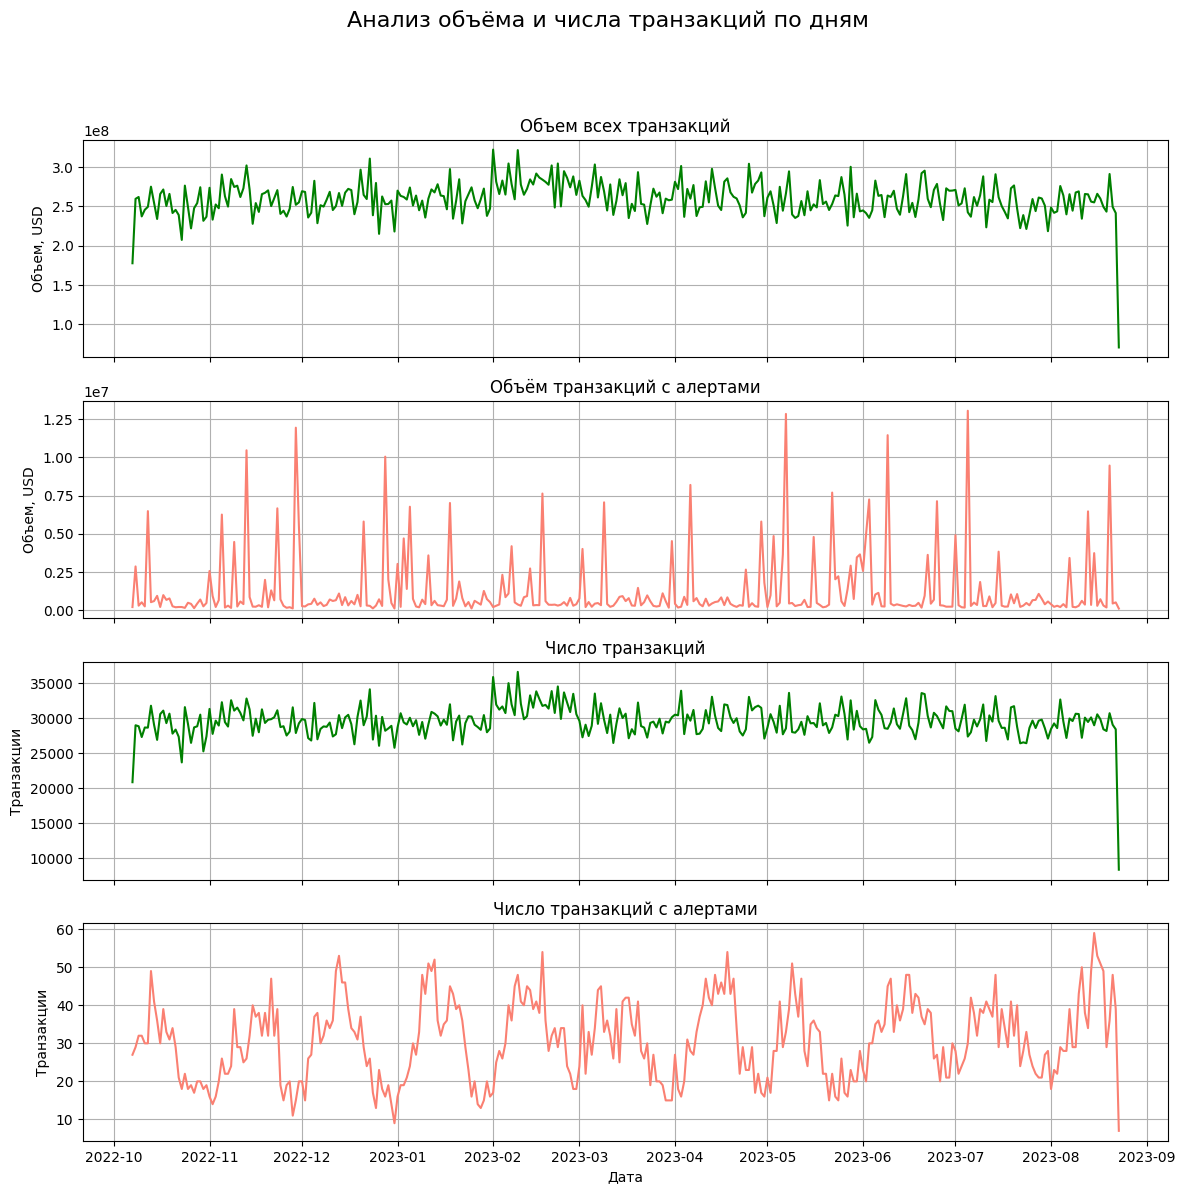

In [24]:
# Создаём колонку с суммой подозрительных транзакций
df['Suspicious_amount'] = df['Amount'] * df['Is_laundering']

# Группировка по дню (Date уже без времени)
daily = df.groupby('Date').agg(
    total_amount=('Amount', 'sum'),
    transaction_count=('Amount', 'count'),
    suspicious_count=('Is_laundering', 'sum'),
    suspicious_amount=('Suspicious_amount', 'sum')
)

# Построение графиков
fig, axes = plt.subplots(4, 1, figsize=(14, 13), sharex=True)

# 1. Сумма всех переводов
axes[0].plot(daily.index, daily['total_amount'], color='green')
axes[0].set_title('Объем всех транзакций')
axes[0].set_ylabel('Объем, USD')
axes[0].grid(True)

# 4. Сумма подозрительных переводов с алертами
axes[1].plot(daily.index, daily['suspicious_amount'], color='salmon')
axes[1].set_title('Объём транзакций с алертами')
axes[1].set_ylabel('Объем, USD')
axes[1].grid(True)

# 2. Кол-во транзакций
axes[2].plot(daily.index, daily['transaction_count'], color='green')
axes[2].set_title('Число транзакций')
axes[2].set_ylabel('Транзакции')
axes[2].grid(True)

# 3. Кол-во подозрительных транзакций
axes[3].plot(daily.index, daily['suspicious_count'], color='salmon')
axes[3].set_title('Число транзакций с алертами')
axes[3].set_ylabel('Транзакции')
axes[3].grid(True)

# Общая настройка
plt.xlabel('Дата')
plt.suptitle('Анализ объёма и числа транзакций по дням', fontsize=16)
plt.show()

### 1.3 Валюта

**Таблица долей валют отправки и получения**

In [25]:
send_currency = df["Payment_currency_iso"].value_counts(normalize=True).round(4) * 100
receive_currency = df["Received_currency_iso"].value_counts(normalize=True).round(4) * 100

currency_table = pd.DataFrame({
    "Валюта": sorted(set(send_currency.index).union(set(receive_currency.index)))
})
currency_table["Отправления, %"] = currency_table["Валюта"].map(send_currency).fillna(0)
currency_table["Получения, %"] = currency_table["Валюта"].map(receive_currency).fillna(0)

currency_table["Max (%)"] = currency_table[["Отправления, %", "Получения, %"]].max(axis=1)

currency_table = currency_table.sort_values(by="Max (%)", ascending=False).reset_index(drop=True)

currency_table.drop(columns="Max (%)", inplace=True)

print("Таблица долей валют отправки и получения")
display(currency_table)

Таблица долей валют отправки и получения


,Валюта,"Отправления, %","Получения, %"
0,GBP,95.73,92.41
1,EUR,1.23,2.44
2,ALL,0.26,0.48
3,MAD,0.27,0.48
4,JPY,0.27,0.48
5,MXN,0.26,0.48
6,PKR,0.29,0.48
7,NGN,0.29,0.47
8,INR,0.26,0.46
9,USD,0.27,0.46


**Валютные пары (отправление -> получение)**

In [26]:
currency_pairs = (
    df.groupby(["Payment_currency_iso", "Received_currency_iso"])
    .size()
    .reset_index(name="Число транзакций")
)

currency_pairs["Доля, %"] = (currency_pairs["Число транзакций"] / currency_pairs["Число транзакций"].sum() * 100).round(2)

currency_pairs = currency_pairs.rename(columns={
    "Payment_currency_iso": "Валюта отправления",
    "Received_currency_iso": "Валюта получения"
})

currency_pairs = currency_pairs.sort_values("Доля, %", ascending=False).reset_index(drop=True)

print("Топ 10 валютных пар по доле от общего количества транзакций")
display(currency_pairs.head(10))


Топ 10 валютных пар по доле от общего количества транзакций


,Валюта отправления,Валюта получения,Число транзакций,"Доля, %"
0,GBP,GBP,8414112,88.52
1,GBP,EUR,220504,2.32
2,EUR,GBP,106608,1.12
3,GBP,JPY,43517,0.46
4,GBP,MAD,43461,0.46
5,GBP,PKR,43895,0.46
6,GBP,MXN,43174,0.45
7,GBP,ALL,43040,0.45
8,GBP,NGN,42696,0.45
9,GBP,INR,41719,0.44


**Хитмап для валютных пар**

In [27]:
total_pairs = df.groupby(["Payment_currency_iso", "Received_currency_iso"]).size().unstack(fill_value=0)

laundering_df = df[df["Is_laundering"] == 1]
laundering_pairs = laundering_df.groupby(["Payment_currency_iso", "Received_currency_iso"]).size().unstack(fill_value=0)

laundering_share = (laundering_pairs / total_pairs).fillna(0).round(4)

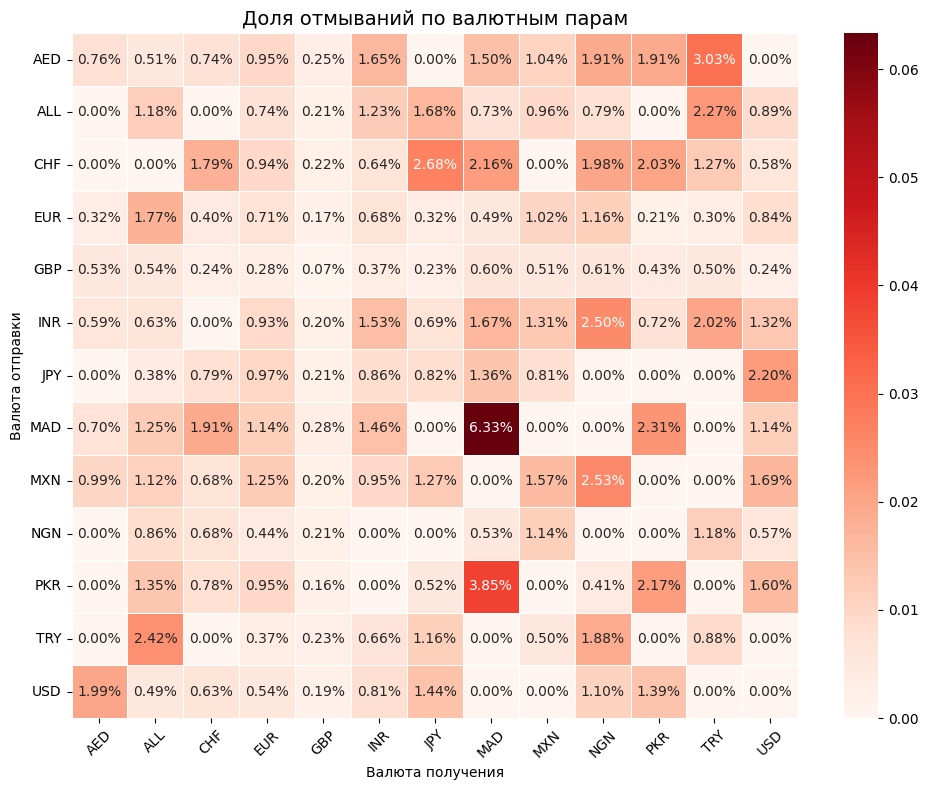

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(laundering_share, annot=True, fmt=".2%", cmap="Reds", linewidths=0.5)

plt.title("Доля отмываний по валютным парам", fontsize=14)
plt.xlabel("Валюта получения")
plt.ylabel("Валюта отправки")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 1.4 География транзакций

**Проверка на наличие стран, в которых присутствуют только получатели или только отправители**

In [29]:
senders = set(df["Sender_bank_location"].unique())
receivers = set(df["Receiver_bank_location"].unique())

only_senders = sorted(senders - receivers)

only_receivers = sorted(receivers - senders)

if not only_senders and not only_receivers:
    print("❗Все страны участвуют как в исходящих, так и во входящих транзакциях")
else:
    if only_senders:
        print("❗Страны, которые встречаются только как отправители")
        for country in only_senders:
            print("-", country)
    else:
        print("❗Нет стран, которые встречаются только как отправители")
    
    if only_receivers:
        print("\nСтраны, которые встречаются только как получатели")
        for country in only_receivers:
            print("-", country)
    else:
        print("❗Нет стран, которые встречаются только как получатели")

❗Все страны участвуют как в исходящих, так и во входящих транзакциях


**Барплоты для долей от общего объема исходящих и входящих переводов по странам**

In [30]:
sender_volume = df.groupby('Sender_bank_location')['Amount'].sum().sort_values(ascending=False)
receiver_volume = df.groupby('Receiver_bank_location')['Amount'].sum().sort_values(ascending=False)

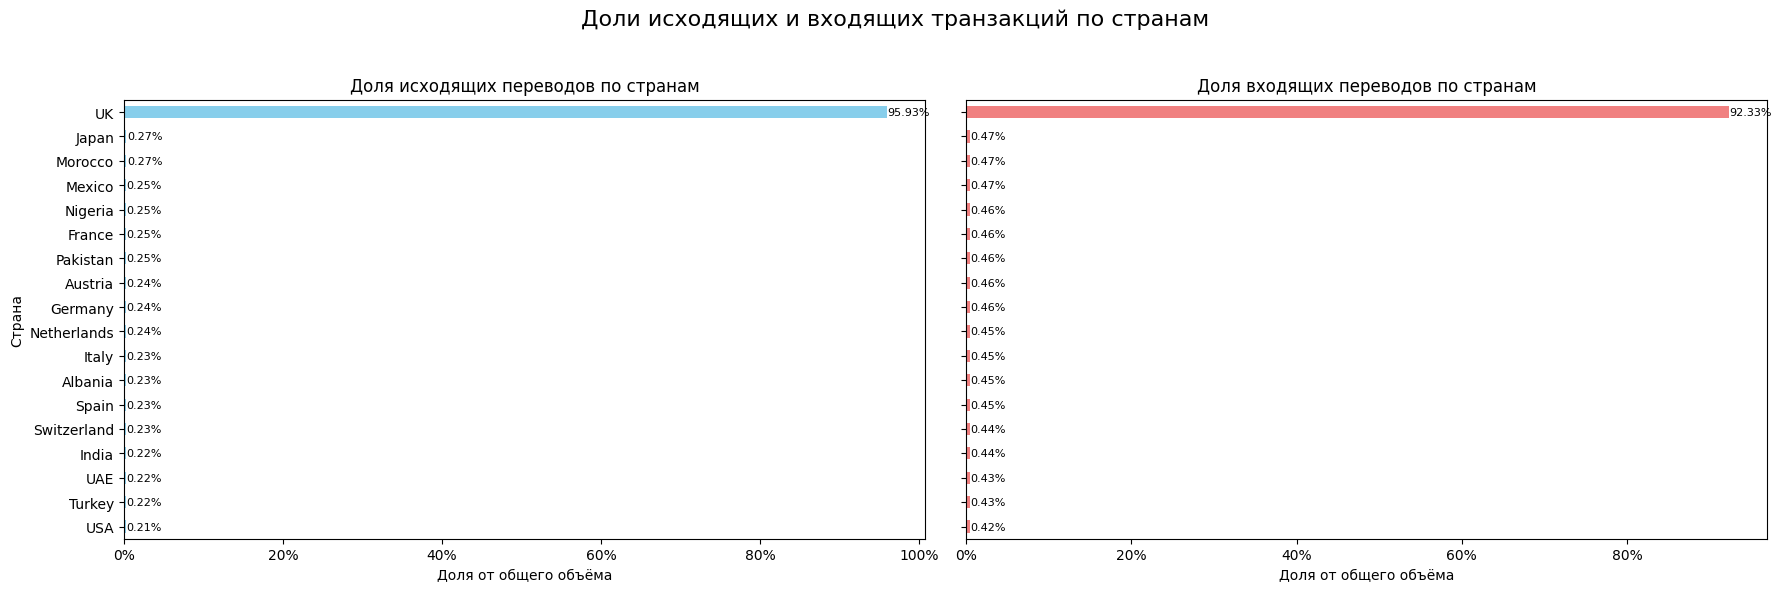

In [31]:
sender_volume = df.groupby('Sender_bank_location')['Amount'].sum()
receiver_volume = df.groupby('Receiver_bank_location')['Amount'].sum()

sender_share = (sender_volume / sender_volume.sum()).sort_values(ascending=False)
receiver_share = (receiver_volume / receiver_volume.sum()).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, max(6, len(sender_share) * 0.3)), sharey=True)

sender_share.sort_values().plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Доля исходящих переводов по странам')
axes[0].set_xlabel('Доля от общего объёма')
axes[0].set_ylabel('Страна')
axes[0].xaxis.set_major_formatter(lambda x, _: f"{x:.0%}")

for i, (country, val) in enumerate(sender_share.sort_values().items()):
    axes[0].text(val + 0.001, i, f"{val:.2%}", va='center', fontsize=8)

receiver_share_sorted = receiver_share.sort_values()
receiver_share_sorted.plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_title('Доля входящих переводов по странам')
axes[1].set_xlabel('Доля от общего объёма')
axes[1].set_ylabel('Страна')
axes[1].xaxis.set_major_formatter(lambda x, _: f"{x:.0%}")

for i, (country, val) in enumerate(receiver_share_sorted.items()):
    axes[1].text(val + 0.001, i, f"{val:.2%}", va='center', fontsize=8)

plt.suptitle('Доли исходящих и входящих транзакций по странам', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Таблица долей от общего количества исходящих и входящих переводов по странам**

In [32]:
# Подсчёт долей по странам отправителей и получателей
send_geo = df["Sender_bank_location"].value_counts(normalize=True).round(4) * 100
receive_geo = df["Receiver_bank_location"].value_counts(normalize=True).round(4) * 100

# Объединение в таблицу
geo_table = pd.DataFrame({
    "Страна": sorted(set(send_geo.index).union(set(receive_geo.index)))
})
geo_table["Отправления, %"] = geo_table["Страна"].map(send_geo).fillna(0)
geo_table["Получения, %"] = geo_table["Страна"].map(receive_geo).fillna(0)

# Сортировка по наибольшему значению
geo_table["Максимум (%)"] = geo_table[["Отправления, %", "Получения, %"]].max(axis=1)
geo_table = geo_table.sort_values("Максимум (%)", ascending=False).drop(columns="Максимум (%)").reset_index(drop=True)

# Вывод
print("❗ География банков отправителей и получателей")
display(geo_table)

❗ География банков отправителей и получателей


,Страна,"Отправления, %","Получения, %"
0,UK,96.61,93.26
1,Albania,0.19,0.41
2,Austria,0.19,0.41
3,France,0.20,0.41
4,Morocco,0.19,0.41
5,Germany,0.20,0.41
6,Pakistan,0.21,0.41
7,Japan,0.19,0.41
8,Mexico,0.19,0.40
9,Nigeria,0.21,0.40


**Хитмап для пар стран**

In [33]:
same_country = (df["Sender_bank_location"] == df["Receiver_bank_location"])
same_percent = same_country.mean().round(4) * 100
print(f"❗Внутренние транзакции: {round(same_percent, 2)}%")

❗Внутренние транзакции: 90.17%


In [34]:
total_geo = df.groupby(["Sender_bank_location", "Receiver_bank_location"]).size().unstack(fill_value=0)
laundering_df = df[df["Is_laundering"] == 1]
laundering_geo = laundering_df.groupby(["Sender_bank_location", "Receiver_bank_location"]).size().unstack(fill_value=0)
laundering_share_geo = (laundering_geo / total_geo).fillna(0).round(4)

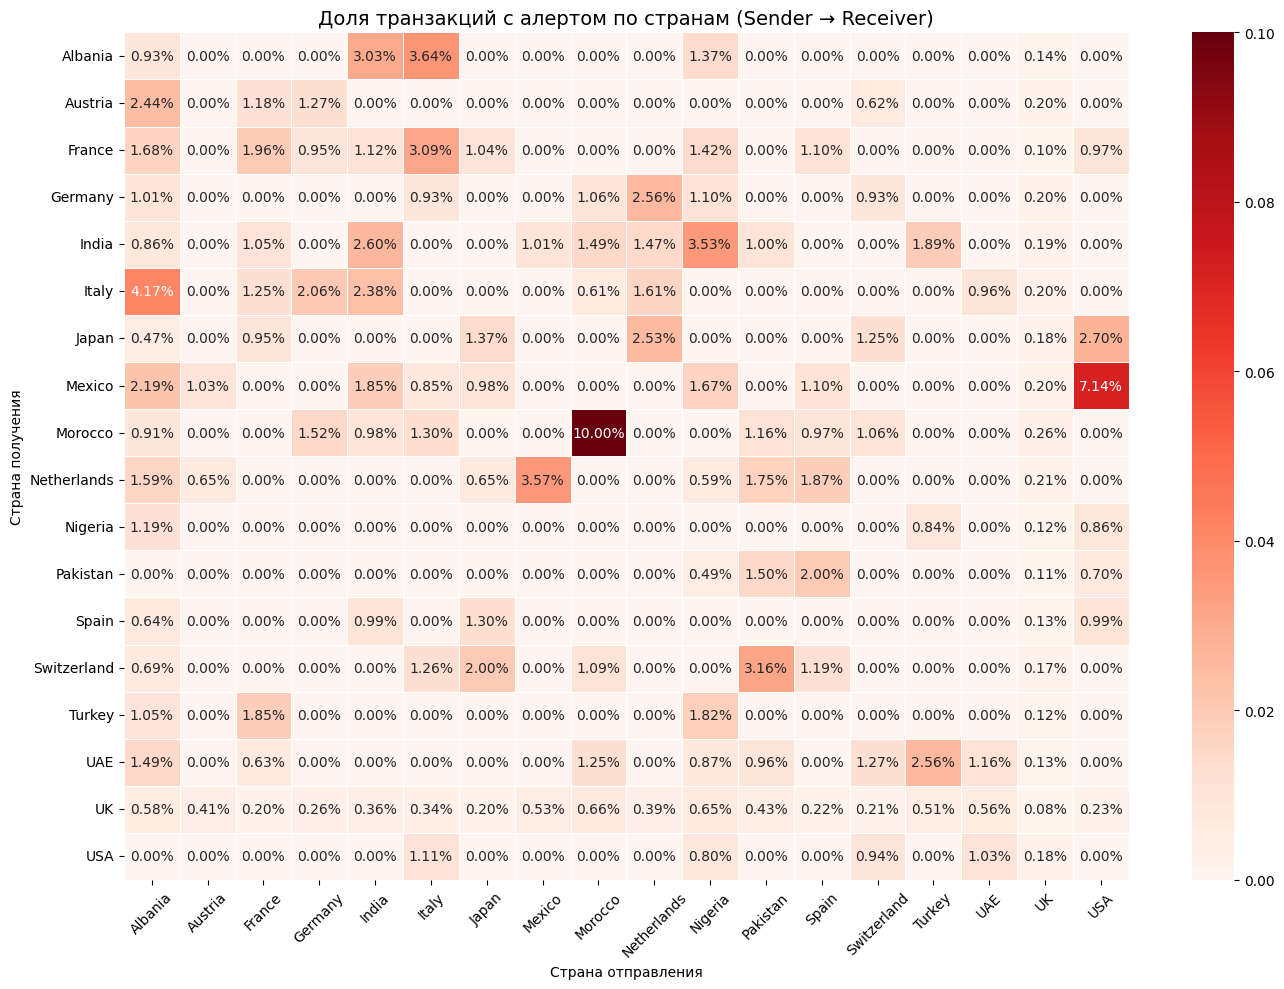

In [35]:
plt.figure(figsize=(14, 10))
sns.heatmap(laundering_share_geo, annot=True, fmt=".2%", cmap="Reds", linewidths=0.5)

plt.title("Доля транзакций с алертом по странам (Sender → Receiver)", fontsize=14)
plt.xlabel("Страна отправления")
plt.ylabel("Страна получения")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 1.5 Объем транзакций

_Все транзакции_

**Графики распределения объема транзакций (обычное и логарифмическое)**

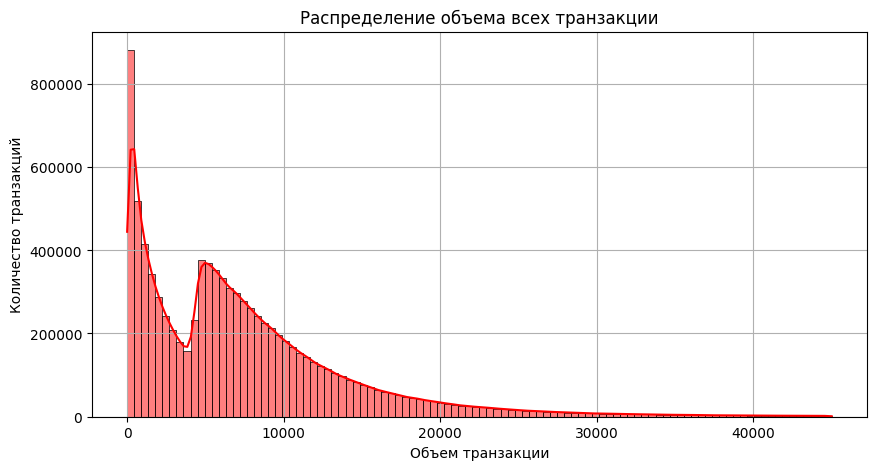

In [36]:
upper_bound = df["Amount"].quantile(0.99)

plt.figure(figsize=(10, 5))
sns.histplot(df[df["Amount"] <= upper_bound]["Amount"],
             bins=100, kde=True, color="red")

plt.title("Распределение объема всех транзакции")
plt.xlabel("Объем транзакции")
plt.ylabel("Количество транзакций")
plt.grid()
plt.show()

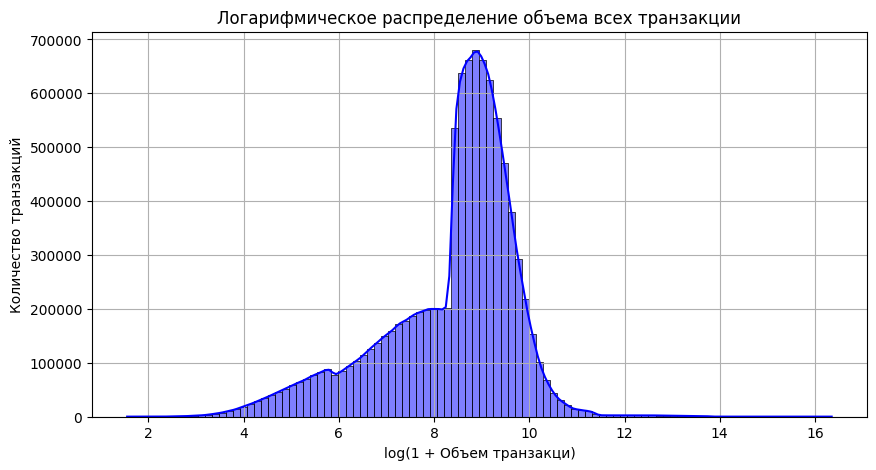

In [37]:
df["log_amount"] = np.log1p(df["Amount"])

plt.figure(figsize=(10, 5))
sns.histplot(df["log_amount"], bins=100, kde=True, color="blue")
plt.title("Логарифмическое распределение объема всех транзакции")
plt.xlabel("log(1 + Объем транзакци)")
plt.ylabel("Количество транзакций")
plt.grid()
plt.show()

*Транзакции с алертом*

**Графики распределения объема транзакций с алертом (обычное и логарифмическое)**

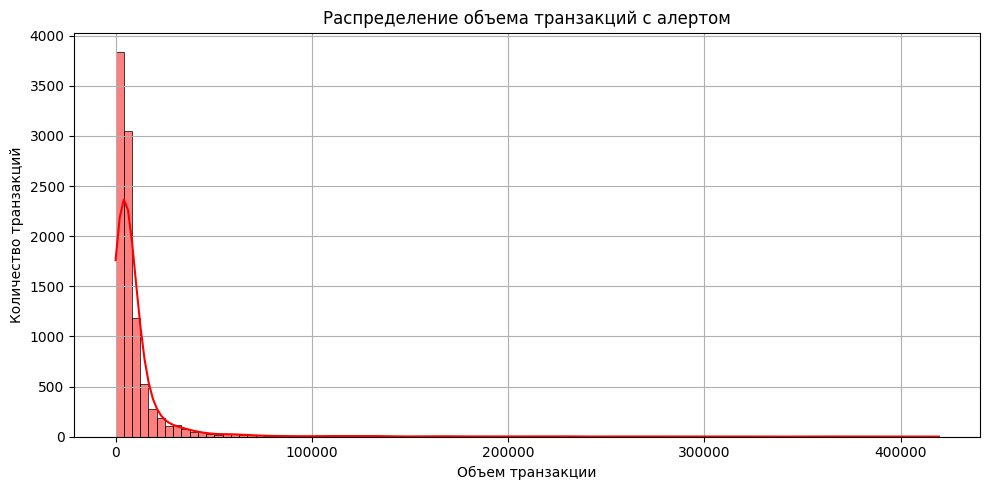

In [38]:
laundering_df = df[df["Is_laundering"] == 1]

upper_bound_laundering = laundering_df["Amount"].quantile(0.99)

plt.figure(figsize=(10, 5))
sns.histplot(
    laundering_df[laundering_df["Amount"] <= upper_bound_laundering]["Amount"],
    bins=100,
    kde=True,
    color="red"
)

plt.title("Распределение объема транзакций с алертом")
plt.xlabel("Объем транзакции")
plt.ylabel("Количество транзакций")
plt.grid()
plt.tight_layout()
plt.show()

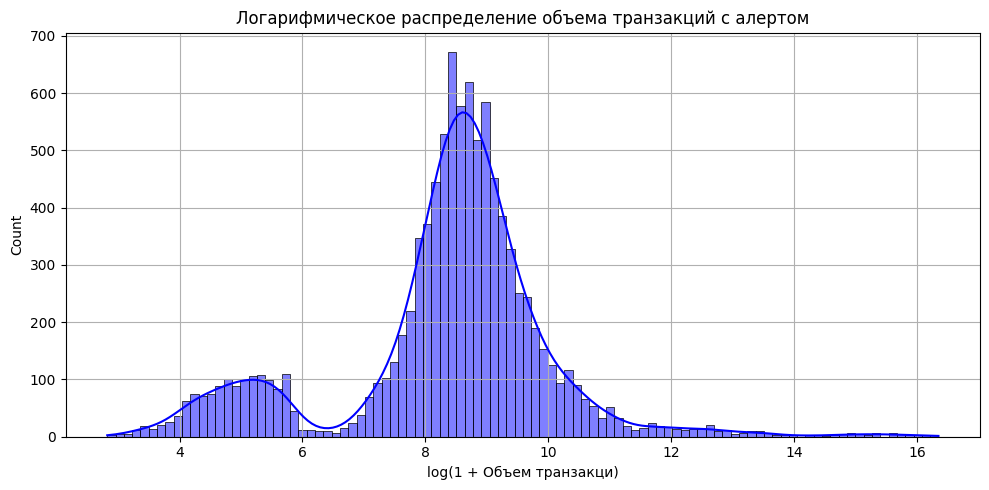

In [39]:
laundering_df = df[df["Is_laundering"] == 1].copy()
laundering_df["log_amount"] = np.log1p(laundering_df["Amount"])

plt.figure(figsize=(10, 5))
sns.histplot(laundering_df["log_amount"], bins=100, kde=True, color="blue")

plt.title("Логарифмическое распределение объема транзакций с алертом")
plt.xlabel("log(1 + Объем транзакци)")
plt.grid()
plt.tight_layout()
plt.show()

**Боксплот для нормальных транзакций и транзакций с алертом**

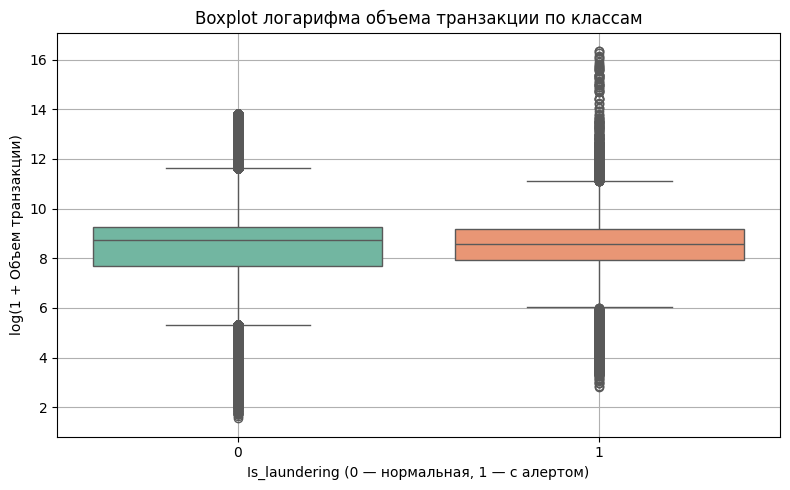

In [40]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Is_laundering", y="log_amount", palette="Set2")

plt.title("Boxplot логарифма объема транзакции по классам")
plt.xlabel("Is_laundering (0 — нормальная, 1 — с алертом)")
plt.ylabel("log(1 + Объем транзакции)")
plt.grid()
plt.tight_layout()
plt.show()

### 1.6 Аккаунты

In [41]:
senders = set(df["Sender_account"].unique())
receivers = set(df["Receiver_account"].unique())

n_senders = len(senders)
n_receivers = len(receivers)
n_total_unique = len(senders.union(receivers))

only_senders = sorted(senders - receivers)
only_receivers = sorted(receivers - senders)
both_roles = sorted(senders & receivers)

n_only_senders = len(only_senders)
n_only_receivers = len(only_receivers)
n_both_roles = len(both_roles)

print("❗Аккаунты, встречающиеся только как отправители:", n_only_senders,
      f"({n_only_senders / n_total_unique:.2%} от общего числа уникальных аккаунтов)")

print("\n❗Аккаунты, встречающиеся только как получатели:", n_only_receivers,
      f"({n_only_receivers / n_total_unique:.2%} от общего числа уникальных аккаунтов)")

print("\n❗Аккаунты с двойной ролью (и отправитель, и получатель):", n_both_roles,
      f"({n_both_roles / n_total_unique:.2%} от общего числа уникальных аккаунтов)")

❗Аккаунты, встречающиеся только как отправители: 203194 (23.75% от общего числа уникальных аккаунтов)

❗Аккаунты, встречающиеся только как получатели: 562745 (65.78% от общего числа уникальных аккаунтов)

❗Аккаунты с двойной ролью (и отправитель, и получатель): 89521 (10.46% от общего числа уникальных аккаунтов)


**Барплот самых активных аккаунтов получателей и отправителей транзакций с алертами**

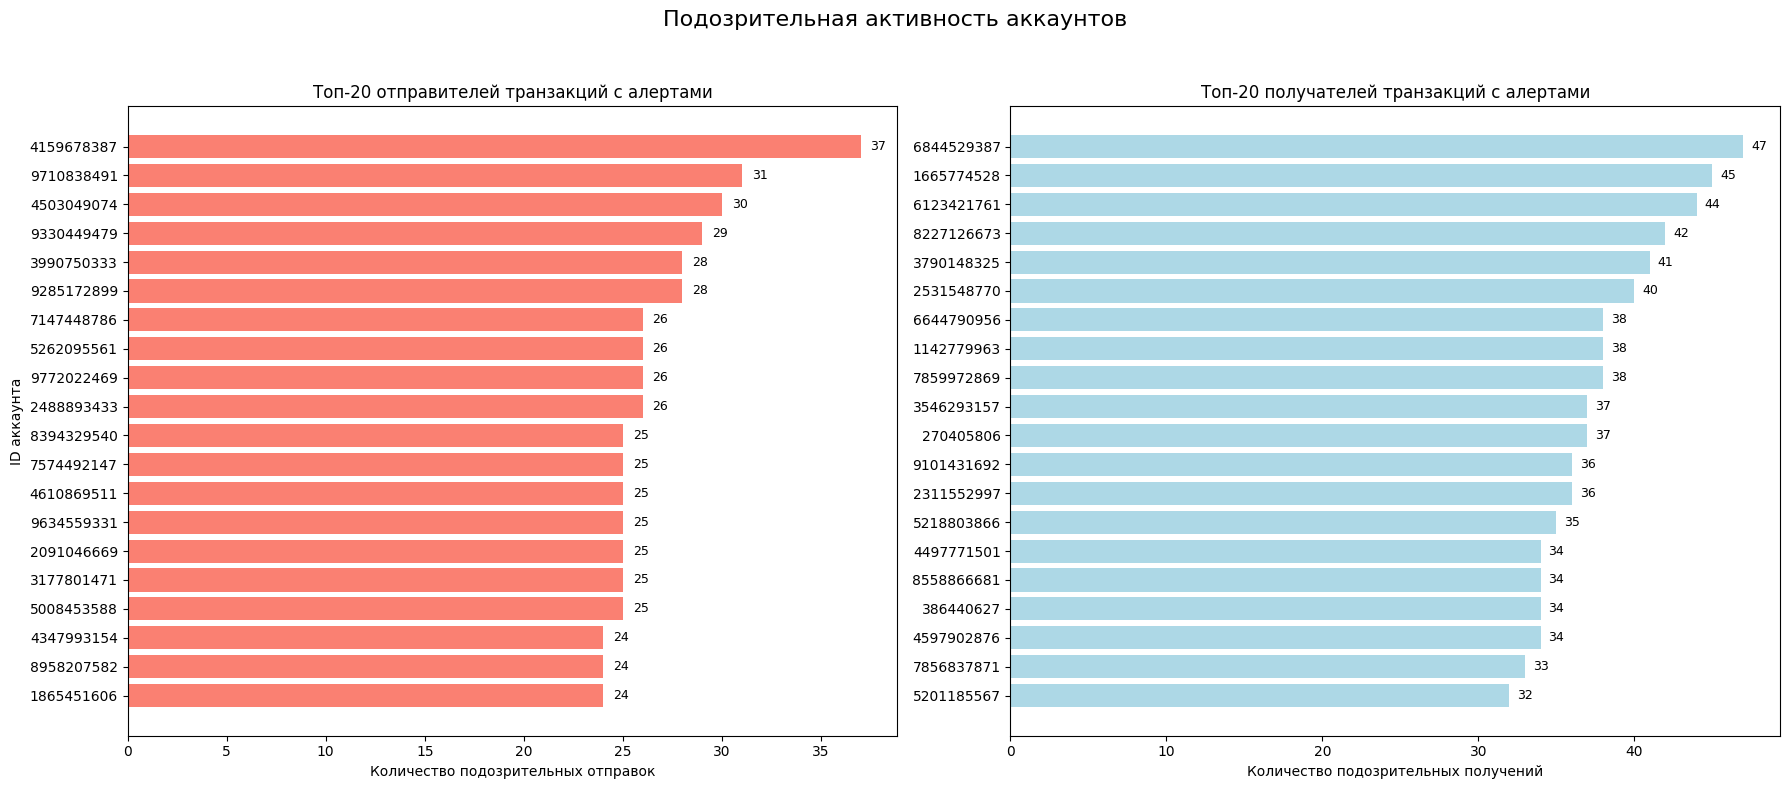

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Анализ подозрительной активности аккаунтов
laundering_senders = df[df['Is_laundering'] == 1]['Sender_account'].value_counts()
laundering_receivers = df[df['Is_laundering'] == 1]['Receiver_account'].value_counts()
total_senders = df['Sender_account'].value_counts()
total_receivers = df['Receiver_account'].value_counts()

laundering_activity = pd.DataFrame({
    'laundering_sent': laundering_senders,
    'total_sent': total_senders,
    'laundering_received': laundering_receivers,
    'total_received': total_receivers
}).fillna(0)

laundering_activity['sent_suspicious_rate'] = laundering_activity['laundering_sent'] / laundering_activity['total_sent']
laundering_activity['recv_suspicious_rate'] = laundering_activity['laundering_received'] / laundering_activity['total_received']
laundering_activity['any_laundering'] = (laundering_activity['laundering_sent'] > 0) | (laundering_activity['laundering_received'] > 0)

top_laundering_senders = laundering_activity['laundering_sent'].sort_values(ascending=False).head(20)
top_laundering_receivers = laundering_activity['laundering_received'].sort_values(ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)

# Сортировка
top_laundering_senders_sorted = top_laundering_senders.sort_values()
top_laundering_receivers_sorted = top_laundering_receivers.sort_values()

# 1. Отправители
axes[0].barh(top_laundering_senders_sorted.index.astype(str), top_laundering_senders_sorted.values, color='salmon')
axes[0].set_title('Топ-20 отправителей транзакций с алертами')
axes[0].set_xlabel('Количество подозрительных отправок')
axes[0].set_ylabel('ID аккаунта')
for i, v in enumerate(top_laundering_senders_sorted.values):
    axes[0].text(v + 0.5, i, str(int(v)), va='center', fontsize=9)

# 2. Получатели
axes[1].barh(top_laundering_receivers_sorted.index.astype(str), top_laundering_receivers_sorted.values, color='lightblue')
axes[1].set_title('Топ-20 получателей транзакций с алертами')
axes[1].set_xlabel('Количество подозрительных получений')
for i, v in enumerate(top_laundering_receivers_sorted.values):
    axes[1].text(v + 0.5, i, str(int(v)), va='center', fontsize=9)

plt.suptitle('Подозрительная активность аккаунтов', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### 1.7 Тип платежа

**Доля каждого типа платежей от общего числа**

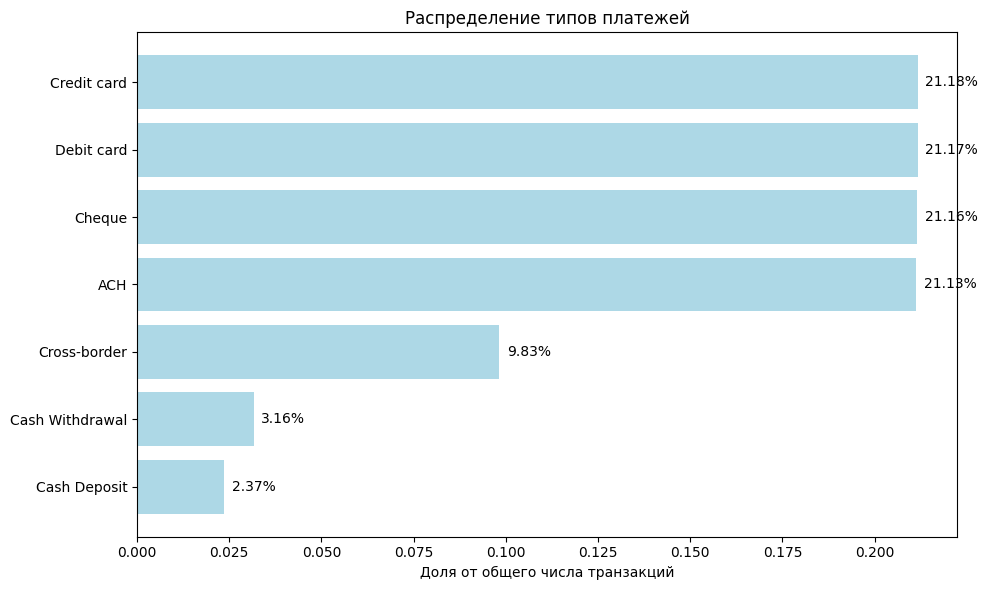

In [43]:
payment_type_counts = df['Payment_type'].value_counts(normalize=True).sort_values()

plt.figure(figsize=(10, 6))
bars = plt.barh(payment_type_counts.index, payment_type_counts.values, color='lightblue')
plt.title('Распределение типов платежей')
plt.xlabel('Доля от общего числа транзакций')

# Добавляем подписи процентов
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height() / 2,
             f"{width:.2%}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

**Доля каждого типа платежа среди транзакций с алертами**

In [44]:
payment_laundering_stats = df.groupby('Payment_type')['Is_laundering'].agg(['count', 'sum'])
payment_laundering_stats['laundering_rate'] = payment_laundering_stats['sum'] / payment_laundering_stats['count']
payment_laundering_stats = payment_laundering_stats.sort_values('laundering_rate', ascending=False)

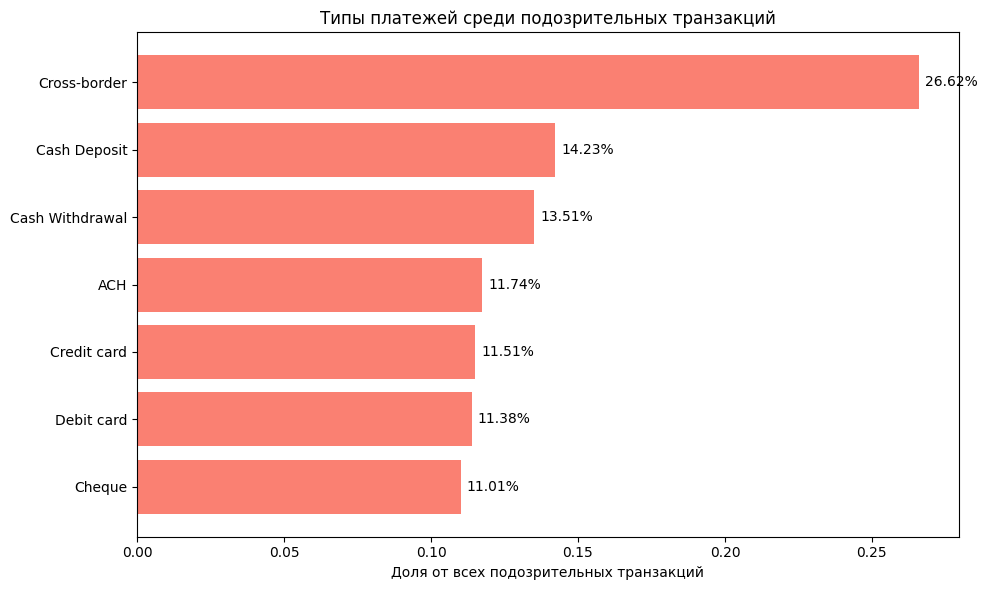

In [45]:
df_laundering = df[df['Is_laundering'] == 1]

laundering_type_share = df_laundering['Payment_type'].value_counts(normalize=True).sort_values()

plt.figure(figsize=(10, 6))
bars = plt.barh(laundering_type_share.index, laundering_type_share.values, color='salmon')
plt.title('Типы платежей среди подозрительных транзакций')
plt.xlabel('Доля от всех подозрительных транзакций')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height() / 2,
             f"{width:.2%}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

**Доля от общего объема платежей, приходящаяся на каждый тип транзакции**

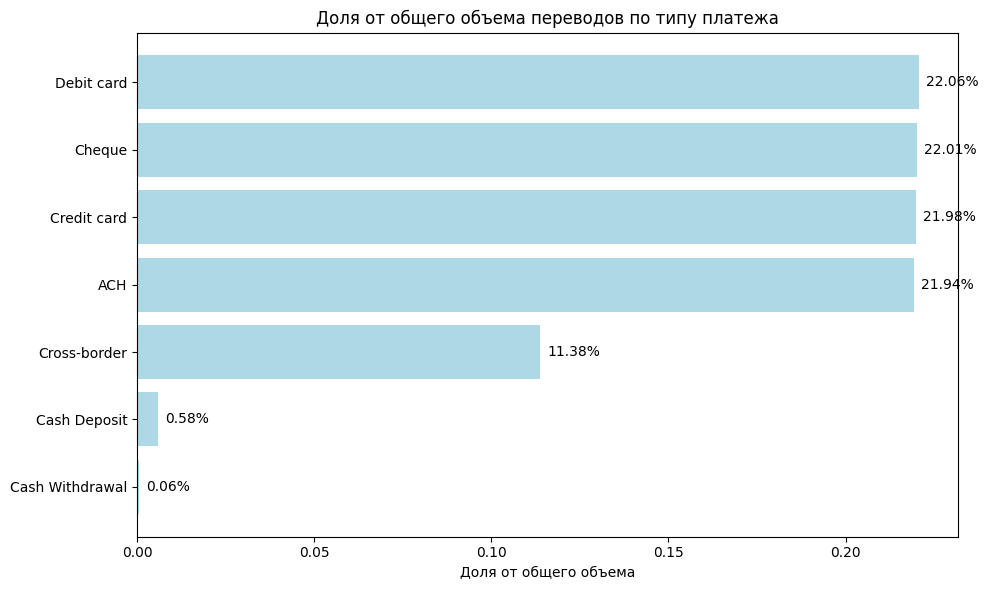

In [46]:
amount_share_by_type = df.groupby('Payment_type')['Amount'].sum()
amount_share_by_type = amount_share_by_type / amount_share_by_type.sum()
amount_share_by_type = amount_share_by_type.sort_values()

plt.figure(figsize=(10, 6))
bars = plt.barh(amount_share_by_type.index, amount_share_by_type.values, color='lightblue')
plt.title('Доля от общего объема переводов по типу платежа')
plt.xlabel('Доля от общего объема')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height() / 2,
             f"{width:.2%}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

**Доля от объема платежей по транзакциям с алертами, приходящаяся на каждый тип транзакции**

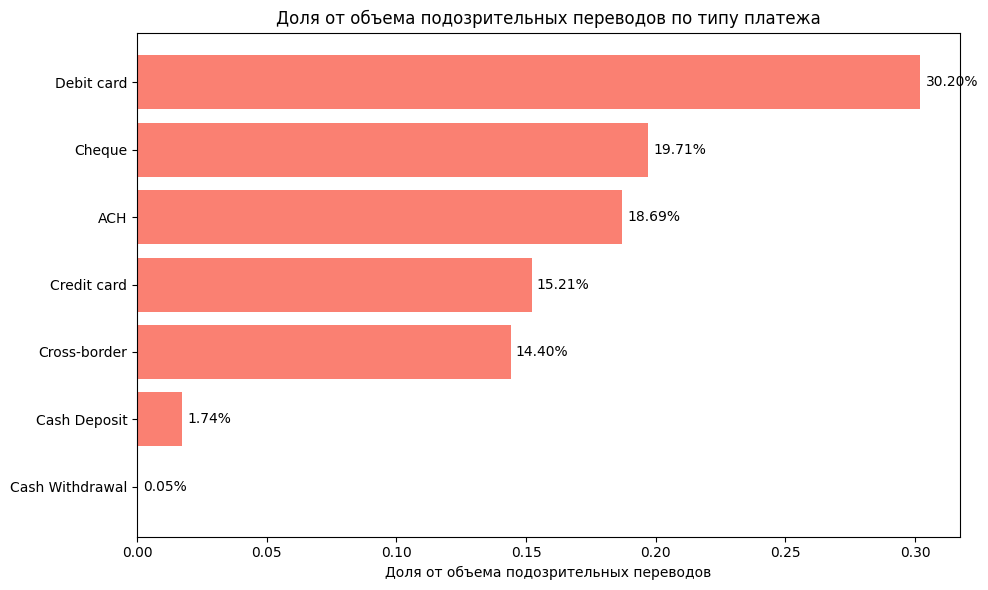

In [47]:
df_laundering = df[df['Is_laundering'] == 1]

amount_share_laundering = df_laundering.groupby('Payment_type')['Amount'].sum()
amount_share_laundering = amount_share_laundering / amount_share_laundering.sum()
amount_share_laundering = amount_share_laundering.sort_values()

plt.figure(figsize=(10, 6))
bars = plt.barh(amount_share_laundering.index, amount_share_laundering.values, color='salmon')
plt.title('Доля от объема подозрительных переводов по типу платежа')
plt.xlabel('Доля от объема подозрительных переводов')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height() / 2,
             f"{width:.2%}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Часть 2. Анализ графа

**Построение графа**

In [46]:
MG = nx.from_pandas_edgelist(
    df,
    source='Sender_account',
    target='Receiver_account',
    edge_attr=['Amount', 'Is_laundering'],
    create_using=nx.MultiDiGraph()
)

print("❗Количество узлов:", MG.number_of_nodes())
print("\n❗Количество рёбер:", MG.number_of_edges())

❗Количество узлов: 855460

❗Количество рёбер: 9504852


In [93]:
unique_pairs = df.groupby(['Sender_account', 'Receiver_account']).size()
n_unique_pairs = unique_pairs.shape[0]

n_multi_edges = (unique_pairs > 1).sum()
share_multi = n_multi_edges / n_unique_pairs

print(f"❗Направлений с неоднократными транзакциями: {n_multi_edges} из {n_unique_pairs} "
      f"({share_multi:.2%} от всех направлений)")

❗Направлений с неоднократными транзакциями: 781631 из 887497 (88.07% от всех направлений)


In [ ]:
in_degrees = dict(MG.in_degree())
out_degrees = dict(MG.out_degree())

degree_df = pd.DataFrame({
    'in_degree': pd.Series(in_degrees),
    'out_degree': pd.Series(out_degrees)
})
degree_df['total_degree'] = degree_df['in_degree'] + degree_df['out_degree']

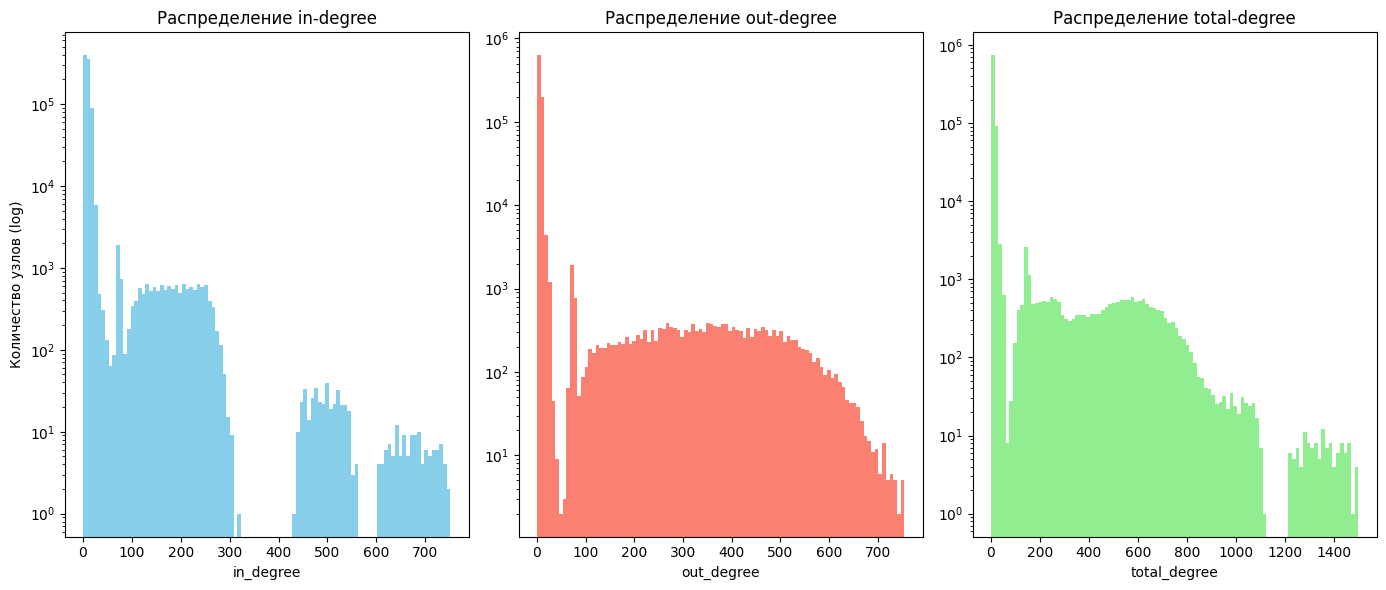

In [99]:
plt.figure(figsize=(14, 6))

# In-degree
plt.subplot(1, 3, 1)
plt.hist(degree_df['in_degree'], bins=100, log=True, color='skyblue')
plt.title('Распределение in-degree')
plt.xlabel('in_degree')
plt.ylabel('Количество узлов (log)')

# Out-degree
plt.subplot(1, 3, 2)
plt.hist(degree_df['out_degree'], bins=100, log=True, color='salmon')
plt.title('Распределение out-degree')
plt.xlabel('out_degree')

# Total-degree
plt.subplot(1, 3, 3)
plt.hist(degree_df['total_degree'], bins=100, log=True, color='lightgreen')
plt.title('Распределение total-degree')
plt.xlabel('total_degree')

plt.tight_layout()
plt.show()

❗Подозрительных хабов: 209 из 8570

❗Из топ-100 хабов в отмывке замечено: 63 


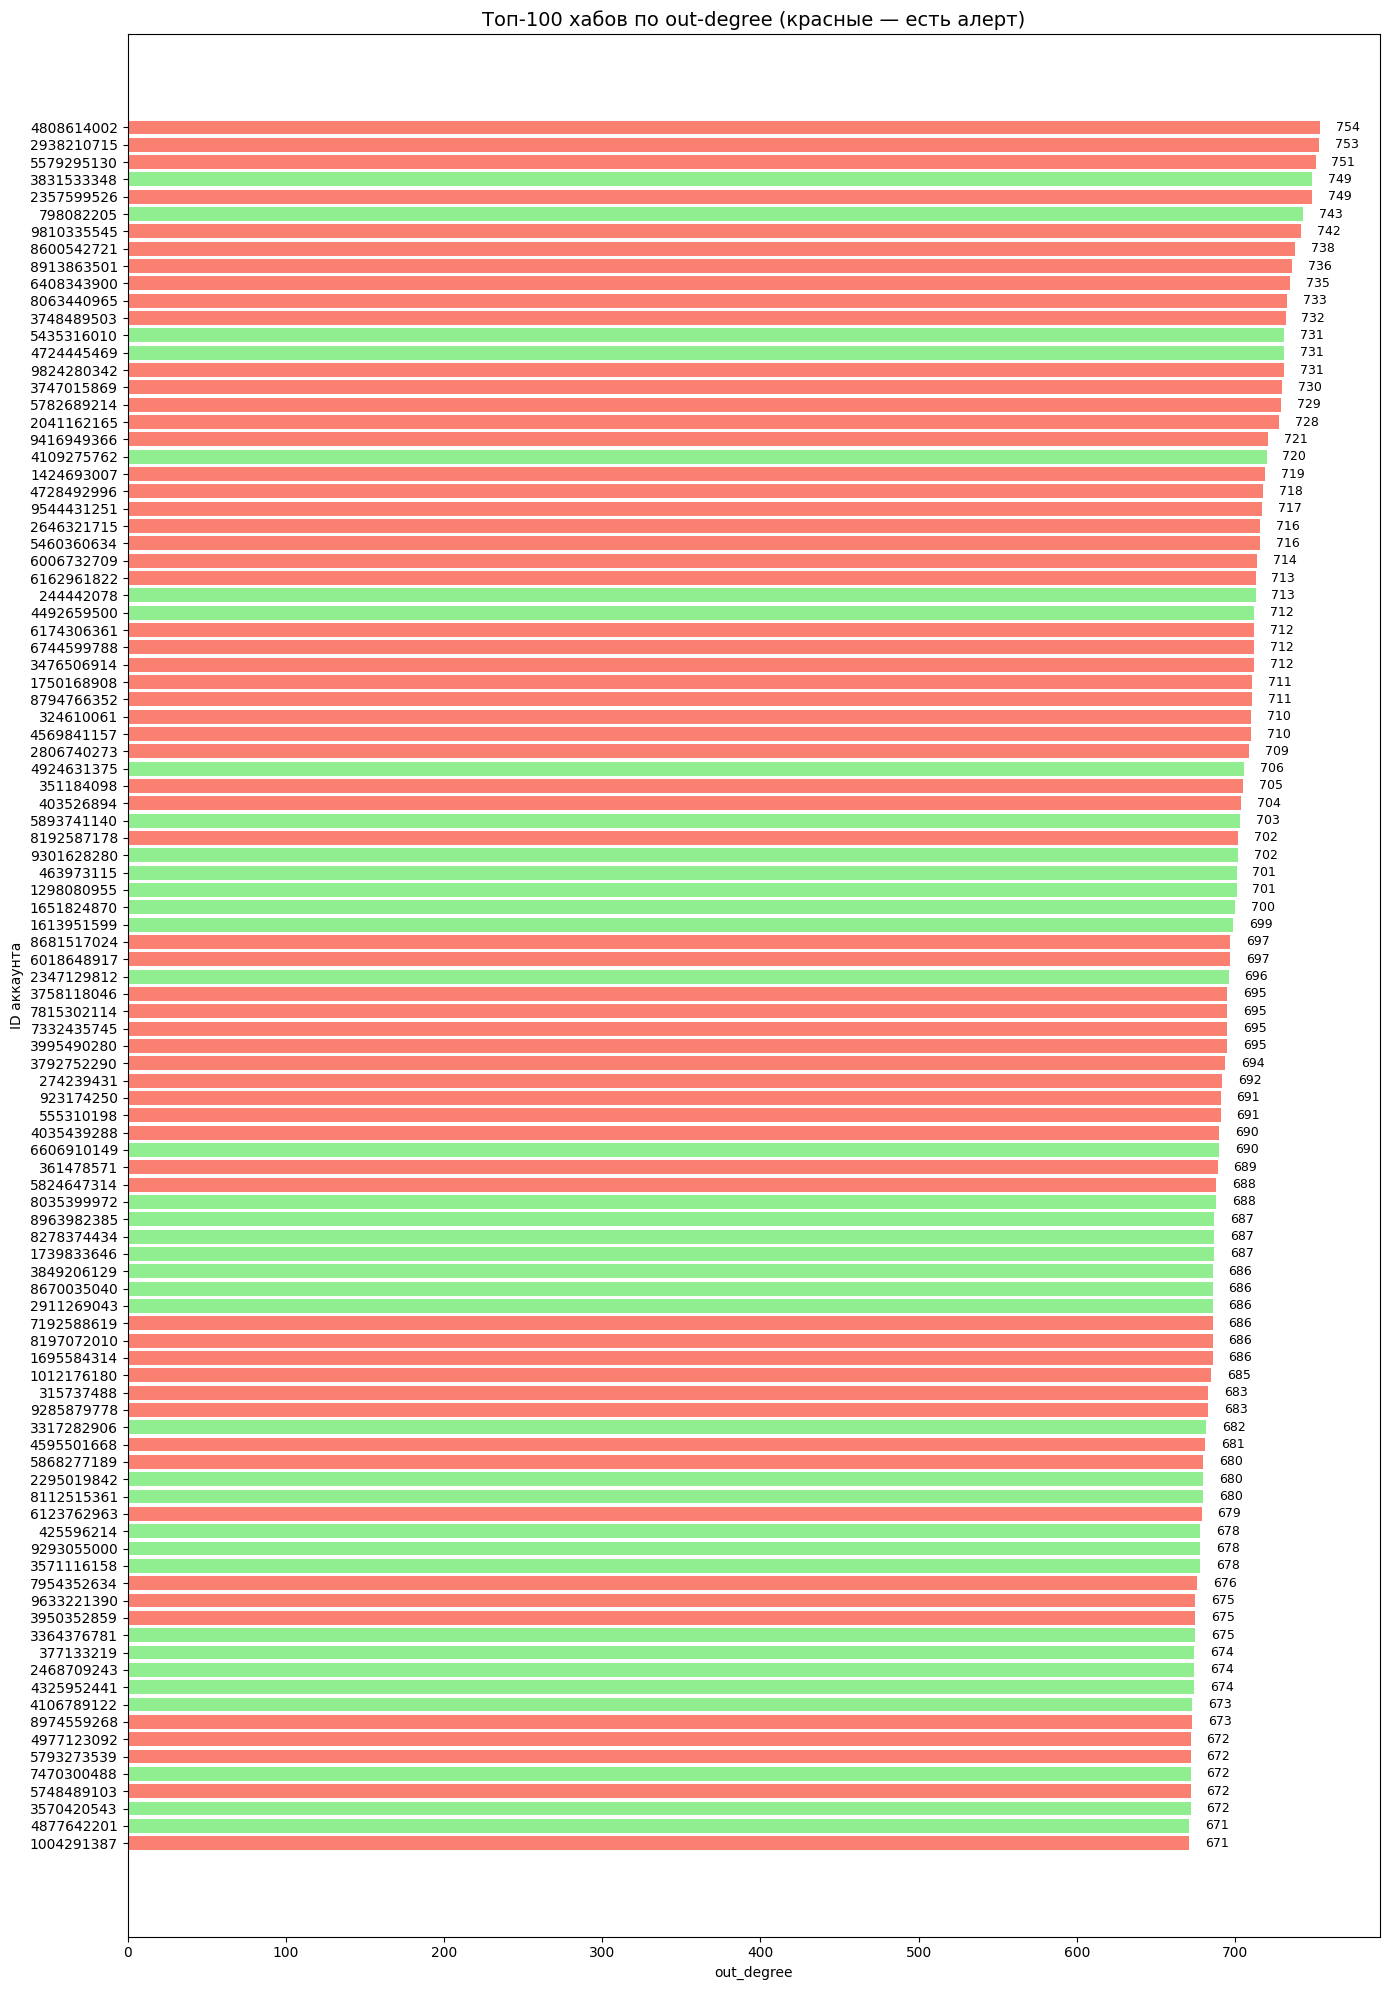

In [ ]:
threshold = degree_df['out_degree'].quantile(0.99)
degree_df['is_hub'] = degree_df['out_degree'] >= threshold

hubs_df = degree_df[degree_df['is_hub']].copy()

laundering_accounts = set(df.loc[df['Is_laundering'] == 1, 'Sender_account']) | \
                      set(df.loc[df['Is_laundering'] == 1, 'Receiver_account'])

hubs_df['laundering_flag'] = hubs_df.index.isin(laundering_accounts)

n_laundering_hubs = hubs_df['laundering_flag'].sum()
print(f"❗Подозрительных хабов: {n_laundering_hubs} из {len(hubs_df)}")

top_hubs = hubs_df.sort_values(by='out_degree', ascending=False).head(100)
colors = top_hubs['laundering_flag'].map({True: 'salmon', False: 'lightgreen'})

n_top_laundering = top_hubs['laundering_flag'].sum()
print(f"\n❗Из топ-100 хабов в отмывке замечено: {n_top_laundering} ")

plt.figure(figsize=(14, 20))
bars = plt.barh(top_hubs.index.astype(str), top_hubs['out_degree'], color=colors)
plt.title('Топ-100 хабов по out-degree (красные — есть алерт)', fontsize=14)
plt.xlabel('out_degree')
plt.ylabel('ID аккаунта')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 10, bar.get_y() + bar.get_height() / 2,
             f"{int(width)}", va='center', fontsize=9)

plt.tight_layout()
plt.show()


**Слабо связные компоненты**

In [121]:
G_undirected = MG.to_undirected()

components = list(nx.connected_components(G_undirected))
largest_component = max(components, key=len)

print(f"❗Число слабосвязных компонент: {len(components):,}")
print(f"\n❗Размер крупнейшей компоненты: {len(largest_component):,} узлов")

❗Число слабосвязных компонент: 15,592

❗Размер крупнейшей компоненты: 954 узлов


**Сильно связные компоненты**

In [122]:
strong_components = list(nx.strongly_connected_components(MG))
largest_strong = max(strong_components, key=len)

print(f"❗Число сильно связанных компонент: {len(strong_components):,}")
print(f"\n❗Размер крупнейшей strongly connected компоненты: {len(largest_strong):,} узлов")

❗Число сильно связанных компонент: 808,212

❗Размер крупнейшей strongly connected компоненты: 34 узлов


**Проверка наличия циклов**

In [123]:
has_cycles = nx.is_directed_acyclic_graph(MG)
print(f"❗Граф содержит циклы? {'Нет' if has_cycles else 'Да'}")

❗Граф содержит циклы? Да


**Расчёт PageRank (*"влияние" или "важность" узла*) и Betweenness (*насколько часто узел находится на кратчайших путях между другими парами узлов*) на подграфе**

In [130]:
G_largest = MG.subgraph(largest_component).copy()

pagerank = nx.pagerank(G_largest, alpha=0.85)
pagerank_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['pagerank'])

betweenness = nx.betweenness_centrality(G_largest, normalized=True)
betweenness_df = pd.DataFrame.from_dict(betweenness, orient='index', columns=['betweenness'])

centrality_df = pagerank_df.join(betweenness_df)
centrality_df = centrality_df.sort_values(by='pagerank', ascending=False)

centrality_df.head(10)

,pagerank,betweenness
9481741805,0.02,0.00
6844529387,0.02,0.00
9833835962,0.01,0.00
2295495393,0.01,0.00
7831668953,0.01,0.00
7312432158,0.01,0.00
1385940946,0.01,0.00
6501504202,0.01,0.00
7221308223,0.01,0.00
714687198,0.01,0.00


In [131]:
centrality_df['laundering_flag'] = centrality_df.index.isin(laundering_accounts)

top_central = centrality_df.sort_values(by='pagerank', ascending=False).head(100)
n_laundering_in_top = top_central['laundering_flag'].sum()
share = n_laundering_in_top / len(laundering_accounts)

print(f"❗Из {len(laundering_accounts):,} laundering-аккаунтов "
      f"{n_laundering_in_top} попали в топ-100 по PageRank "
      f"({share:.2%} от всех подозрительных)")

❗Из 7,902 laundering-аккаунтов 36 попали в топ-100 по PageRank (0.46% от всех подозрительных)


## Часть 3. CatBoost-ансамбль с бутстрап-андерсэмплингом

In [ ]:
df_new = df.drop(columns=['Time', 'Date', 'Laundering_type', 'log_amount', 'Amount_log', 'Is_Normal', 'Suspicious_amount'])
df_new.head()

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Категориальные признаки
categorical_cols = ['Sender_account', 'Receiver_account', 
                    'Sender_bank_location', 'Receiver_bank_location',
                    'Payment_type', 'Payment_currency_iso', 
                    'Received_currency_iso', 'year', 'month', 'weekday', 'hour']
categorical_cols = [col for col in categorical_cols if col in df_new.columns]

# Разделение на train/val/test с сохранением распределения классов
X = df_new.drop(columns=['Is_laundering'])
y = df_new['Is_laundering'].astype(int)

X_temp, X_test_full, y_temp, y_test_full = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_temp, y_temp, test_size=0.3333, stratify=y_temp, random_state=42
)

print(f"Train: {len(X_train_base)} | Val: {len(X_val_base)} | Test (full): {len(X_test_full)}")

Train: 3802130 | Val: 1900781 | Test (full): 3801941


In [ ]:
# Подготовим тестовую выборку с андерсэмплингом (70/30)
df_test = pd.concat([X_test_full, y_test_full], axis=1)
df_test_pos = df_test[df_test['Is_laundering'] == 1]
df_test_neg = df_test[df_test['Is_laundering'] == 0].sample(
    n=int(len(df_test_pos) * (70 / 30)), random_state=999
)
df_test_balanced = pd.concat([df_test_pos, df_test_neg]).sample(frac=1, random_state=42)
X_test = df_test_balanced.drop(columns=['Is_laundering'])
y_test = df_test_balanced['Is_laundering']

print(f"Undersampled Test: {len(X_test)} (Class 1: {y_test.sum()}, Class 0: {len(y_test) - y_test.sum()})")

X_val_base_sample = X_val_base.sample(n=50000, random_state=42)
y_val_base_sample = y_val_base.loc[X_val_base_sample.index]

# Параметры ансамбля
n_models = 5
neg_pos_ratio = 2.33  # 70/30
threshold = 0.5

all_probs = []

# Ансамбль
df_train_base = pd.concat([X_train_base, y_train_base], axis=1)
df_train_pos = df_train_base[df_train_base['Is_laundering'] == 1]
df_train_neg = df_train_base[df_train_base['Is_laundering'] == 0]

import time

models = []

for i in range(n_models):
    print(f"▶ Обучаю модель {i+1}/{n_models}")
    t0 = time.time()

    df_neg_sample = df_train_neg.sample(n=int(len(df_train_pos) * neg_pos_ratio), random_state=100 + i)
    df_sample = pd.concat([df_train_pos, df_neg_sample]).sample(frac=1, random_state=100 + i)

    X_train = df_sample.drop(columns=['Is_laundering'])
    y_train = df_sample['Is_laundering'].astype(int)

    model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.1,
        depth=6,
        cat_features=categorical_cols,
        verbose=100,  # ← чтобы видеть ход итераций
        random_state=100 + i,
        auto_class_weights='Balanced'
    )

    model.fit(
        X_train, y_train,
        eval_set=(X_val_base_sample, y_val_base_sample),  # ← Уменьшенный `val`
        early_stopping_rounds=50
    )

    probs = model.predict_proba(X_test)[:, 1]
    all_probs.append(probs)
    models.append(model)

    print(f"❗ Модель {i+1} обучена за {time.time() - t0:.2f} сек\n")

# Усреднение и финальные метрики
avg_probs = np.mean(all_probs, axis=0)
y_pred = (avg_probs >= threshold).astype(int)

In [ ]:
print("❗Метрики на undersampled тесте:")
print(f"ROC AUC: {roc_auc_score(y_test, avg_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n❗Метрики на полном тесте:")
print(f"ROC AUC: {roc_auc_score(y_test_full, probs_full):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_full, y_pred_full))
print("Confusion Matrix:")
print(confusion_matrix(y_test_full, y_pred_full))

❗Метрики на *undersampled* тесте:
ROC AUC: 0.9655

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9214
           1       0.95      0.80      0.87      3949

    accuracy                           0.93     13163
   macro avg       0.93      0.89      0.91     13163
weighted avg       0.93      0.93      0.92     13163

Confusion Matrix:
[[9053  161]
 [ 809 3140]]

❗Метрики на *полном* тесте:
ROC AUC: 0.9651

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   3797992
           1       0.05      0.80      0.09      3949

    accuracy                           0.98   3801941
   macro avg       0.52      0.89      0.54   3801941
weighted avg       1.00      0.98      0.99   3801941

Confusion Matrix:
[[3734456   63536]
 [    809    3140]]


## Часть 4. LightGBM

**На андерсэмплинге**

In [ ]:
# Андерсэмплированный тест (70/30)
df_test = pd.concat([X_test_full, y_test_full], axis=1)
df_test_pos = df_test[df_test['Is_laundering'] == 1]
df_test_neg = df_test[df_test['Is_laundering'] == 0].sample(
    n=int(len(df_test_pos) * (70 / 30)), random_state=999
)
df_test_balanced = pd.concat([df_test_pos, df_test_neg]).sample(frac=1, random_state=42)

X_test = df_test_balanced.drop(columns=['Is_laundering'])
y_test = df_test_balanced['Is_laundering']


# Подготовка обучающей выборки (тот же андерсэмплинг)
df_train = pd.concat([X_train_base, y_train_base], axis=1)
df_pos = df_train[df_train['Is_laundering'] == 1]
df_neg = df_train[df_train['Is_laundering'] == 0].sample(
    n=int(len(df_pos) * (70 / 30)), random_state=42
)
df_sample = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42)

X_train_lgb = df_sample.drop(columns=['Is_laundering']).copy()
y_train_lgb = df_sample['Is_laundering'].astype(int)

X_test_lgb = X_test.copy()

# Кодирование категориальных признаков в int
for col in categorical_cols:
    le = LabelEncoder()
    full_vals = pd.concat([X_train_lgb[col], X_test_lgb[col]], axis=0).astype(str)
    le.fit(full_vals)

    X_train_lgb[col] = le.transform(X_train_lgb[col].astype(str))
    X_test_lgb[col] = le.transform(X_test_lgb[col].astype(str))

# Модель LGBM
model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

model.fit(
    X_train_lgb,
    y_train_lgb,
    categorical_feature=categorical_cols
)

# Предсказания и метрики
probs = model.predict_proba(X_test_lgb)[:, 1]
preds = model.predict(X_test_lgb)

roc = roc_auc_score(y_test, probs)
f1 = f1_score(y_test, preds)
acc = accuracy_score(y_test, preds)
combined = (roc + f1) / 2

print("LightGBM:")
print(f"ROC AUC     : {roc:.4f}")
print(f"F1-score    : {f1:.4f}")
print(f"Accuracy    : {acc:.4f}")
print(f"Combined : {combined:.4f}")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3950, number of negative: 9216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1263
[LightGBM] [Info] Number of data points in the train set: 13166, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300015 -> initscore=-0.847226
[LightGBM] [Info] Start training from score -0.847226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

**На всей выборке**

In [ ]:
# Копируем X_train_base и X_test (андерсэмплированный тест остаётся для оценки)
X_train_lgb = X_train_base.copy()
y_train_lgb = y_train_base.copy()
X_test_lgb = X_test.copy()

# Кодируем категориальные признаки в int
for col in categorical_cols:
    le = LabelEncoder()
    all_vals = pd.concat([X_train_lgb[col], X_test_lgb[col]], axis=0).astype(str)
    le.fit(all_vals)

    X_train_lgb[col] = le.transform(X_train_lgb[col].astype(str))
    X_test_lgb[col] = le.transform(X_test_lgb[col].astype(str))

# Обучаем LGBM на полной обучающей выборке
model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

model.fit(
    X_train_lgb,
    y_train_lgb,
    categorical_feature=categorical_cols
)

# Предсказания и метрики на андерсэмплированном тесте
probs = model.predict_proba(X_test_lgb)[:, 1]
preds = model.predict(X_test_lgb)

roc = roc_auc_score(y_test, probs)
f1 = f1_score(y_test, preds)
acc = accuracy_score(y_test, preds)
combined = (roc + f1) / 2

print("LightGBM (на полной обучающей выборке):")
print(f"ROC AUC     : {roc:.4f}")
print(f"F1-score    : {f1:.4f}")
print(f"Accuracy    : {acc:.4f}")
print(f"Combined : {combined:.4f}")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3950, number of negative: 3798180
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30100
[LightGBM] [Info] Number of data points in the train set: 3802130, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001039 -> initscore=-6.868562
[LightGBM] [Info] Start training from score -6.868562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [1]:
# Данные: метрики на андерсэмплированном тесте
undersampled_metrics = pd.DataFrame([
    {'Model': 'CatBoost (ансамбль)', 'Training': 'Бутстрап + андерсэмплинг', 'ROC_AUC': 0.9655, 'F1': 0.87},
    {'Model': 'LightGBM', 'Training': 'Полная выборка', 'ROC_AUC': 0.7931, 'F1': 0.2969},
])
undersampled_metrics['Combined'] = (undersampled_metrics['ROC_AUC'] + undersampled_metrics['F1']) / 2

# Данные: метрики на полном тесте
full_metrics = pd.DataFrame([
    {'Model': 'CatBoost (ансамбль)', 'Training': 'Бутстрап + андерсэмплинг', 'ROC_AUC': 0.9651, 'F1': 0.09},
    {'Model': 'LightGBM', 'Training': 'Полная выборка', 'ROC_AUC': 0.7931, 'F1': 0.2969},
])
full_metrics['Combined'] = (full_metrics['ROC_AUC'] + full_metrics['F1']) / 2

# Вывод таблиц
print("Метрики на андерсэмплированном тесте:\n")
print(undersampled_metrics)

print("\nМетрики на полном тесте:\n")
print(full_metrics)

NameError: name 'pd' is not defined